# MMM Example Notebook

In this notebook we work out a simulated example to showcase the MMM API from `pymc-marketing`. We also use a simulation as we want to to *parameter recovery* to better understand the model assumptions. That is, we explicitly set values for our adstock and saturation parameters and revover them back from the model. The data generation process is as an adaptation of the blog post [Media Effect Estimation with PyMC: Adstock, Saturation & Diminishing Returns](https://juanitorduz.github.io/pymc_mmm/) by [Juan Orduz](https://juanitorduz.github.io/).

---
# Part I: Data Generation Process

In Part I of this notebook we focus on the data generating process.

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.preprocessing import MaxAbsScaler
import seaborn as sns

from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM
from pymc_marketing.mmm.utils import generate_fourier_modes

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Generate Data

### 1. Date Range

First we set a time range for our data. We consider wth a bit more than 2 years of data at weekly granularity.

In [2]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

# date range
min_date = pd.to_datetime("2018-04-01")
max_date = pd.to_datetime("2021-09-01")

df = pd.DataFrame(
    data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
).assign(
    year = lambda x: x["date_week"].dt.year,
    month = lambda x: x["date_week"].dt.month,
    dayofyear = lambda x: x["date_week"].dt.dayofyear,
)

n = df.shape[0]
print(f"Number of observations: {n}")

Number of observations: 179


### 2. Media Costs Data

Now we generate synthetic data from two channels $z_1$ and $z_2$. We refer to it as the raw signal as is is going to be the input at the modeling phase. We expect the contribution of each channel to be different, based on the carryover and saturation parameters.

- Raw Signal

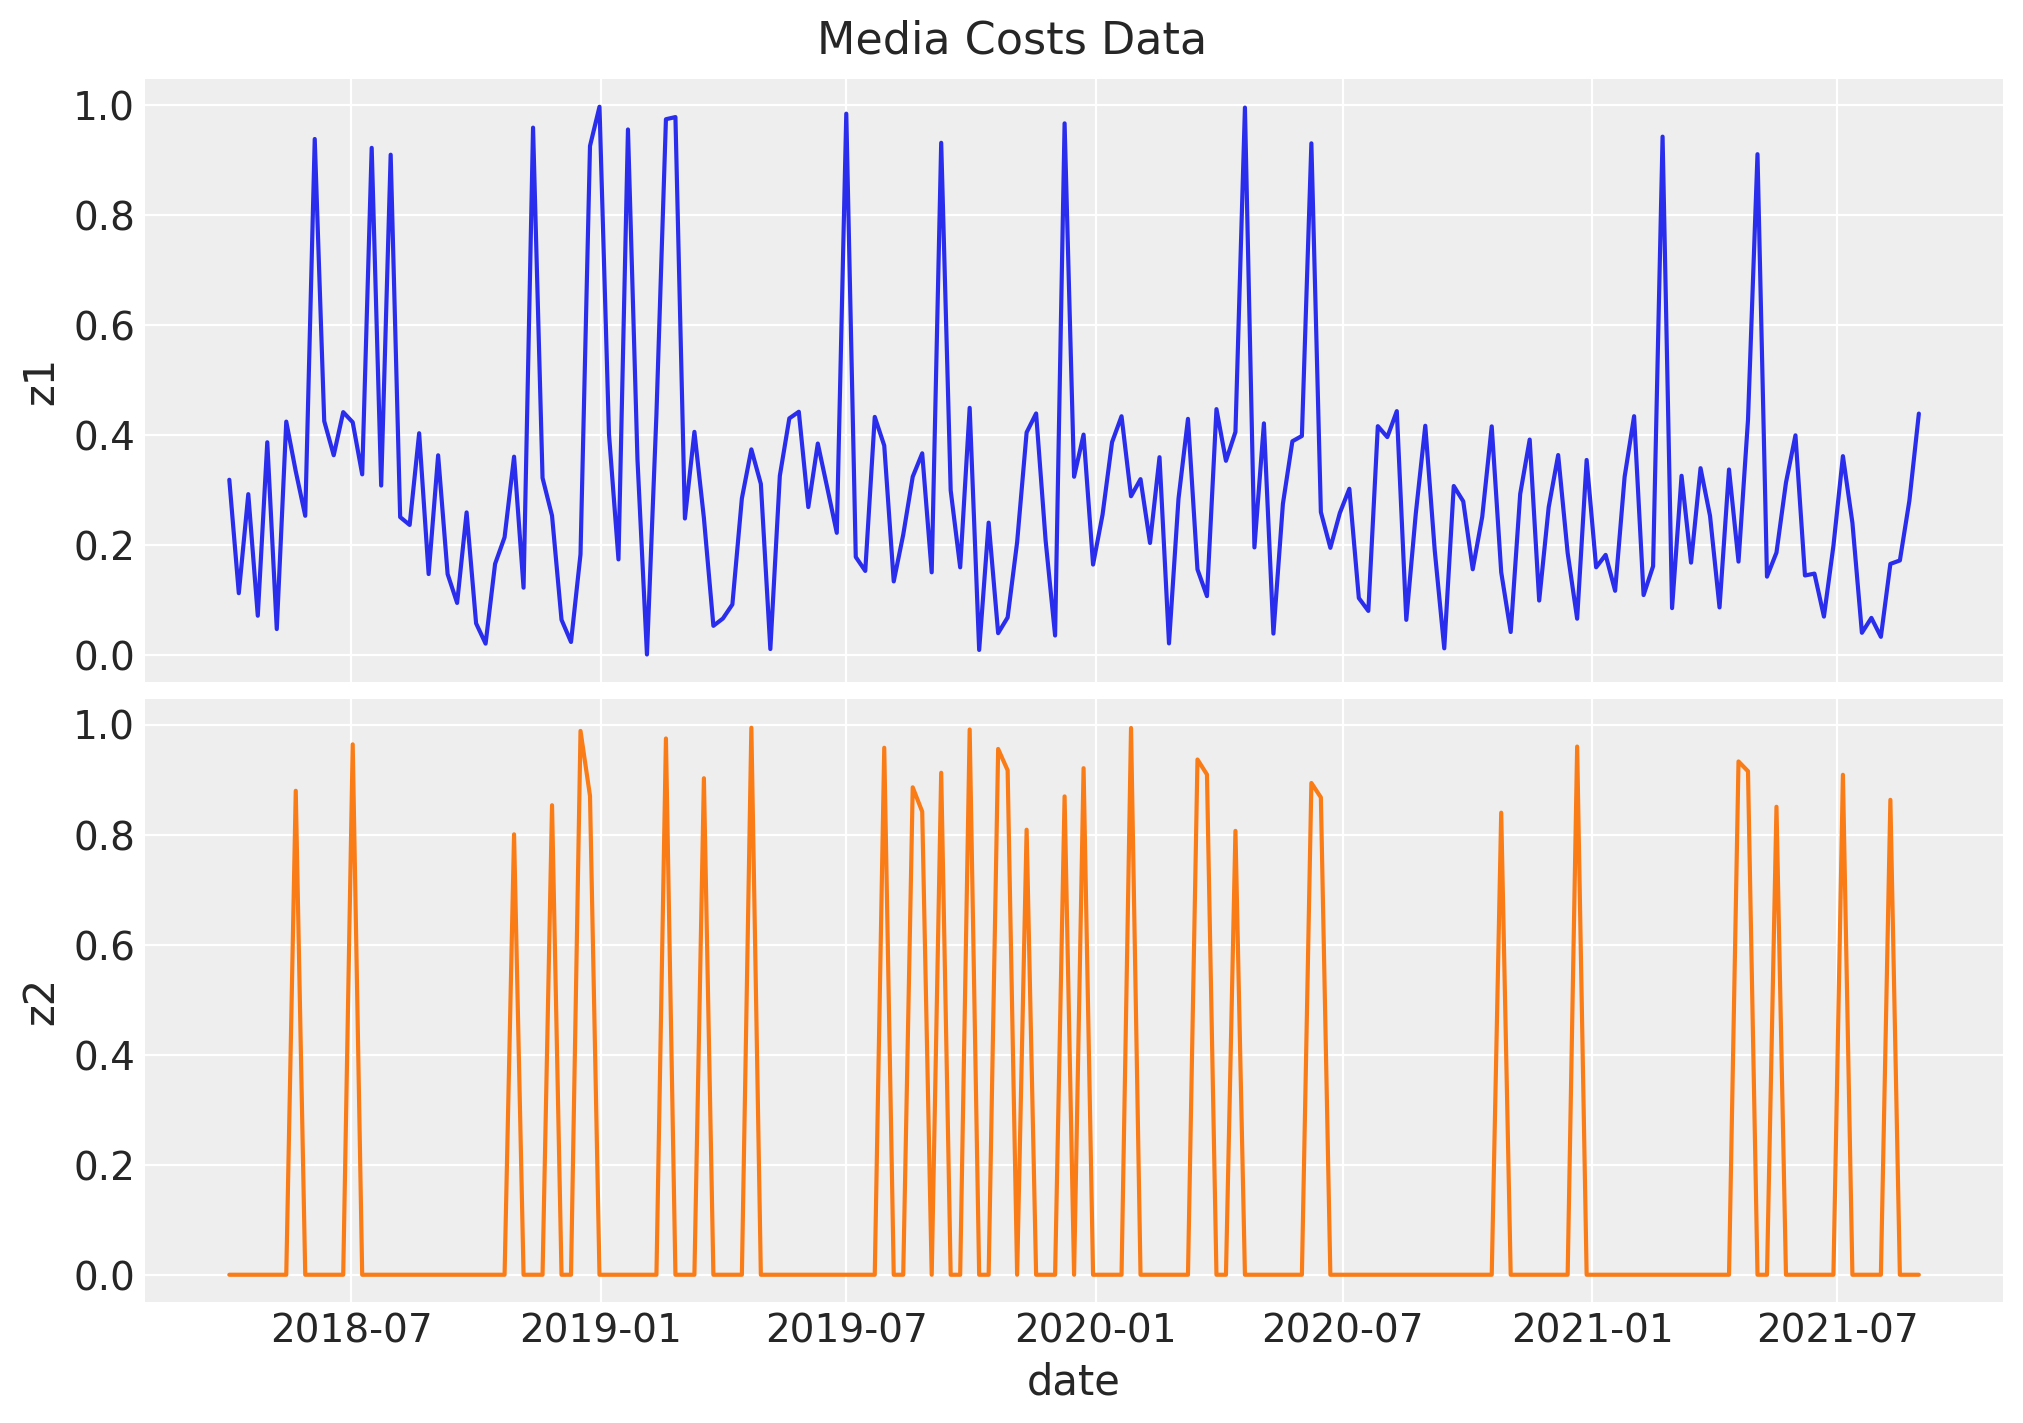

In [3]:
# media data
z1 = rng.uniform(low=0.0, high=1.0, size=n)
df["z1"] = np.where(z1 > 0.9, z1, z1 / 2)

z2 = rng.uniform(low=0.0, high=1.0, size=n)
df["z2"] = np.where(z2 > 0.8, z2, 0)


fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(x="date_week", y="z1", data=df, color="C0", ax=ax[0])
sns.lineplot(x="date_week", y="z2", data=df, color="C1", ax=ax[1])
ax[1].set(xlabel="date")
fig.suptitle("Media Costs Data", fontsize=16);

- Effect Signal

Next, we pass the raw signal through the two transformations: first the geometric adstock (carryover effect) and then the logistic saturation. Note that we set the parameters ourselves, but we will recover them back from the model.

Let's start with the adstock transformation. We set the adstock parameter $0 < \alpha < 1$ to be $0.4$ and $0.2$ for $z_1$ and $z_2$ respectively. We set a maximum lag effect of $8$ weeks.

In [4]:
# apply geometric adstock transformation
alpha1: float = 0.4
alpha2: float = 0.2

df["z1_adstock"] = (
    geometric_adstock(
        x=df["z1"].to_numpy(), alpha=alpha1, l_max=8, normalize=True
    )
    .eval()
    .flatten()
)

df["z2_adstock"] = (
    geometric_adstock(
        x=df["z2"].to_numpy(), alpha=alpha2, l_max=8, normalize=True
    )
    .eval()
    .flatten()
)

Next, we compose the resulting adstock signals with the logistic saturation function. We set the parameter $\lambda > 0$ to be $4$ and $3$ for $z_1$ and $z_2$ respectively.

In [5]:
# apply saturation transformation
lam1: float = 4.0
lam2: float = 3.0

df["z1_adstock_saturated"] = logistic_saturation(
    x=df["z1_adstock"].to_numpy(), lam=lam1
).eval()

df["z2_adstock_saturated"] = logistic_saturation(
    x=df["z2_adstock"].to_numpy(), lam=lam2
).eval()

We can now visualize the effect signal for each channel after each transformation:

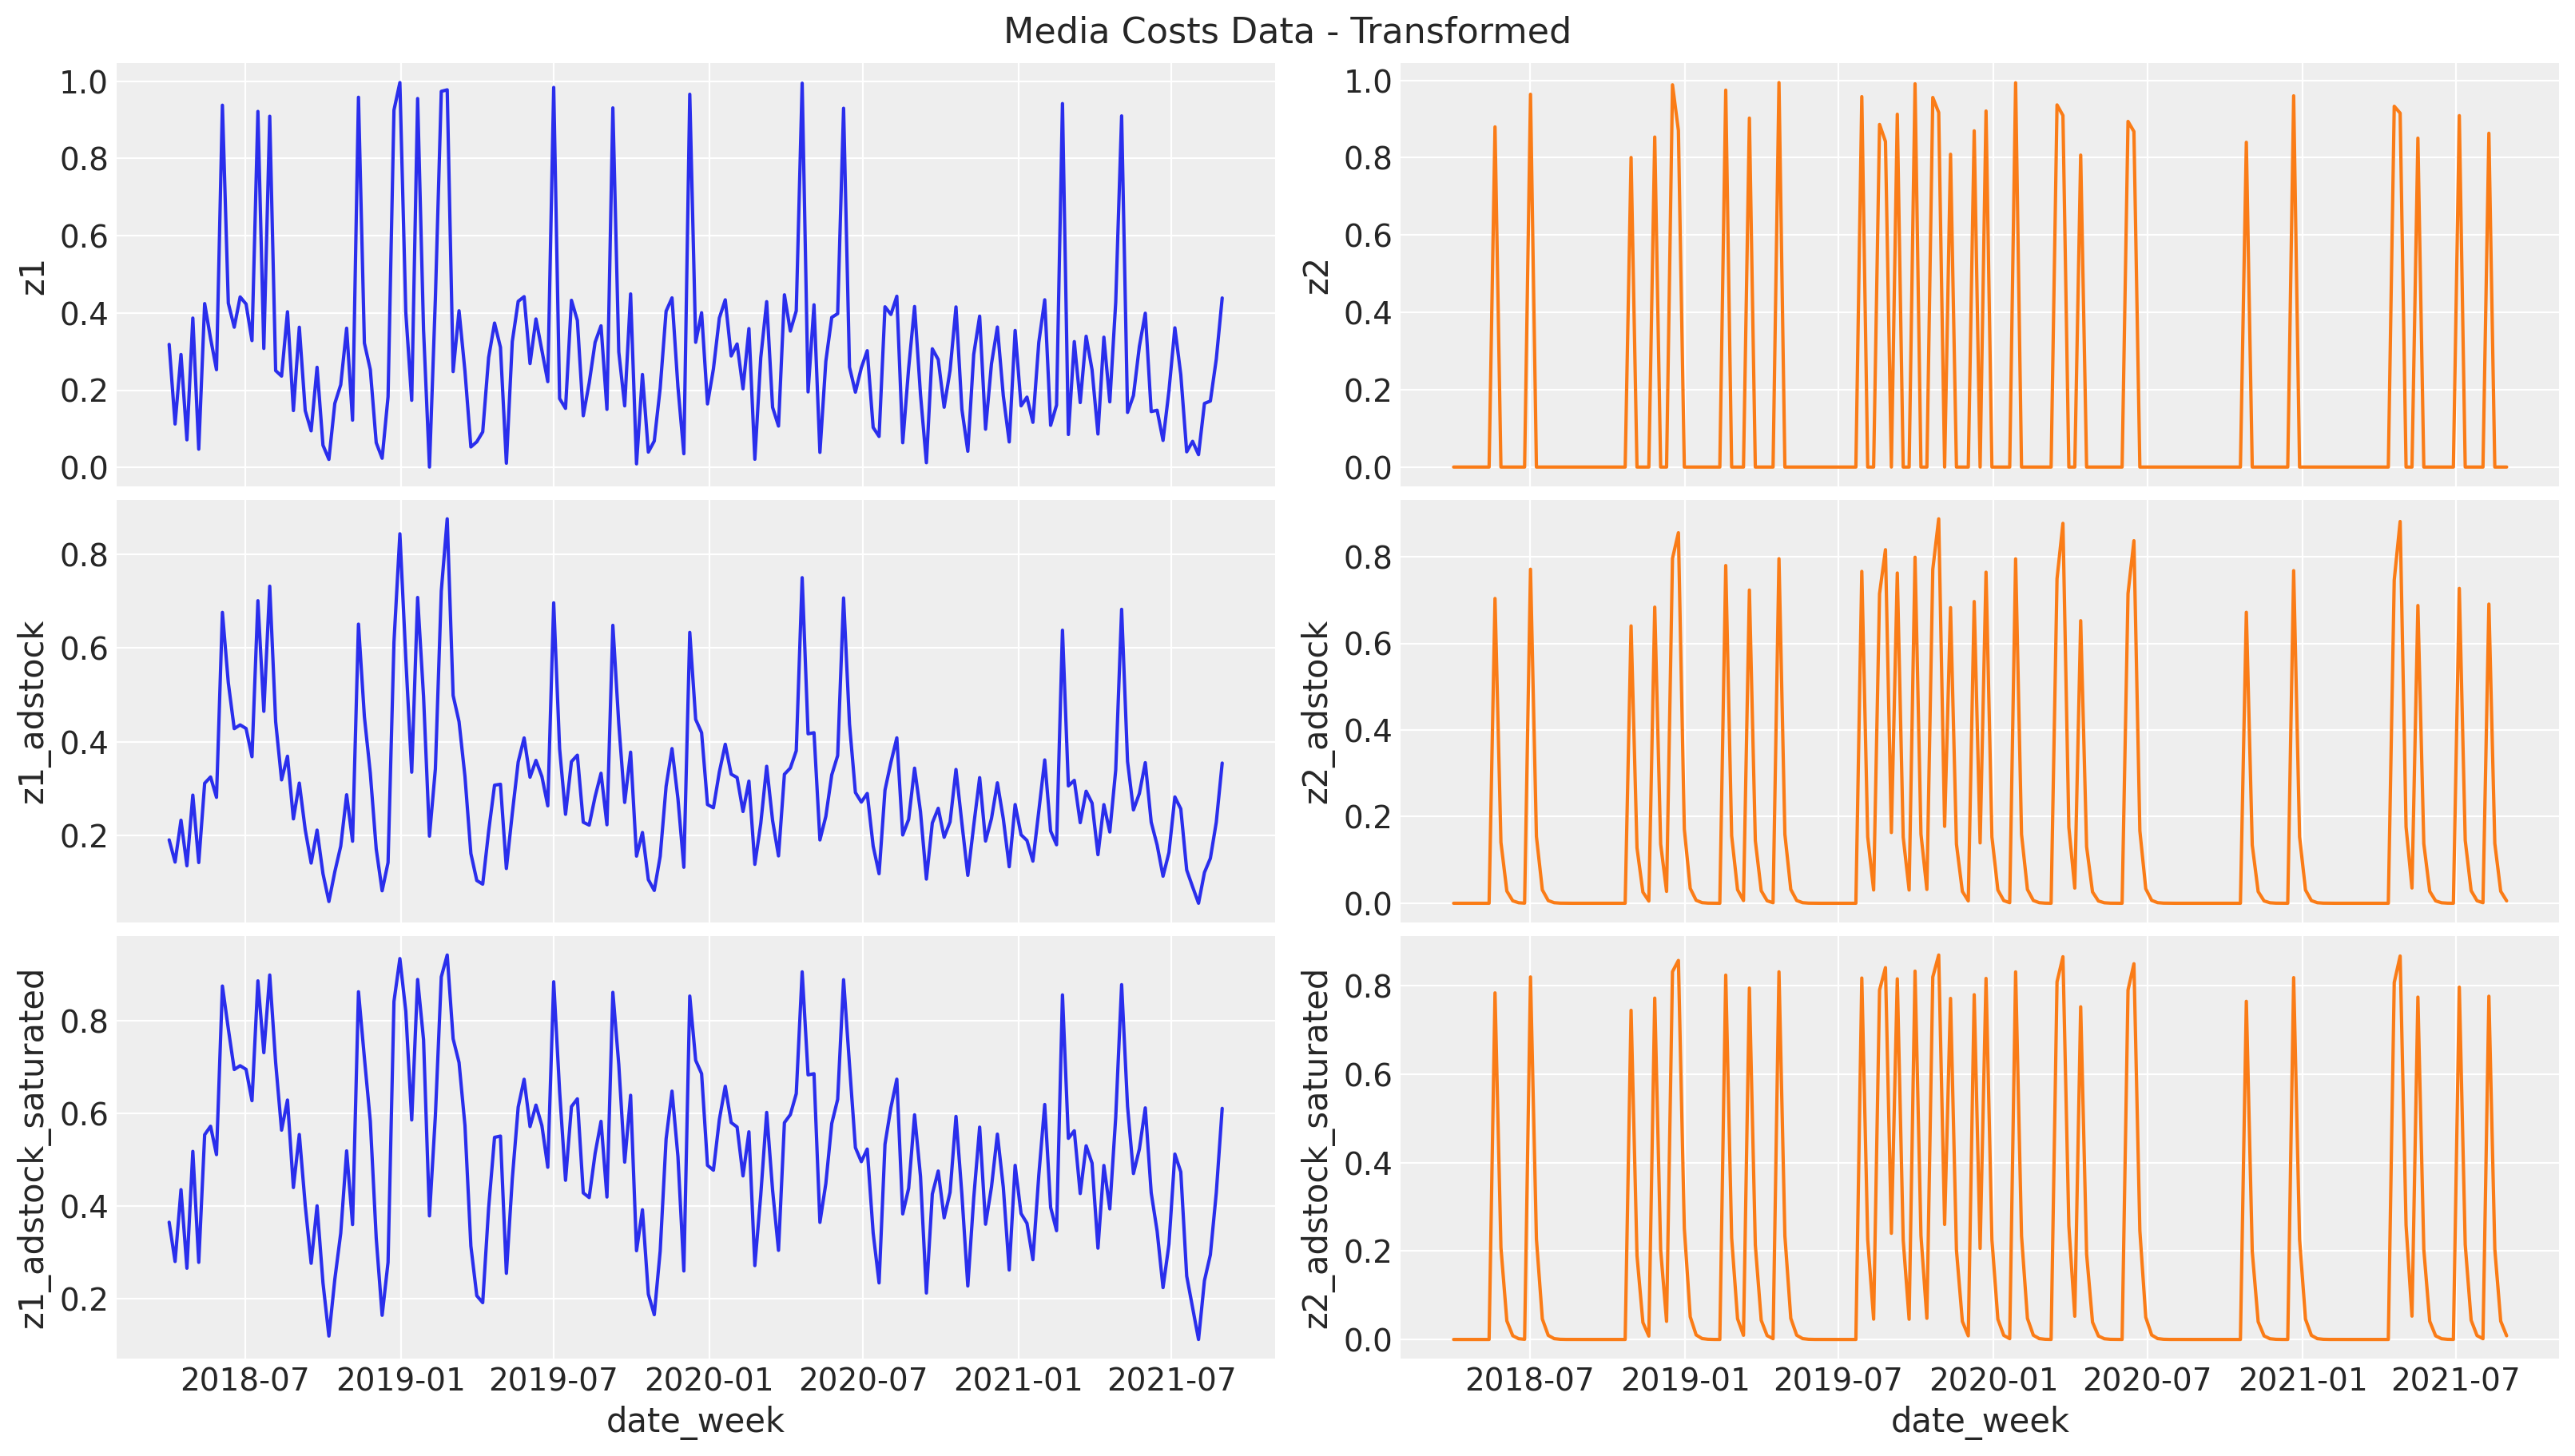

In [6]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(16, 9), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date_week", y="z1", data=df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date_week", y="z2", data=df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date_week", y="z1_adstock", data=df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date_week", y="z2_adstock", data=df, color="C1", ax=ax[1, 1])
sns.lineplot(x="date_week", y="z1_adstock_saturated", data=df, color="C0", ax=ax[2, 0])
sns.lineplot(x="date_week", y="z2_adstock_saturated", data=df, color="C1", ax=ax[2, 1])
fig.suptitle("Media Costs Data - Transformed", fontsize=16);

### 3. Trend \& Seasonal Components

Now we add synthetic trend and seasonal components to the effect signal.

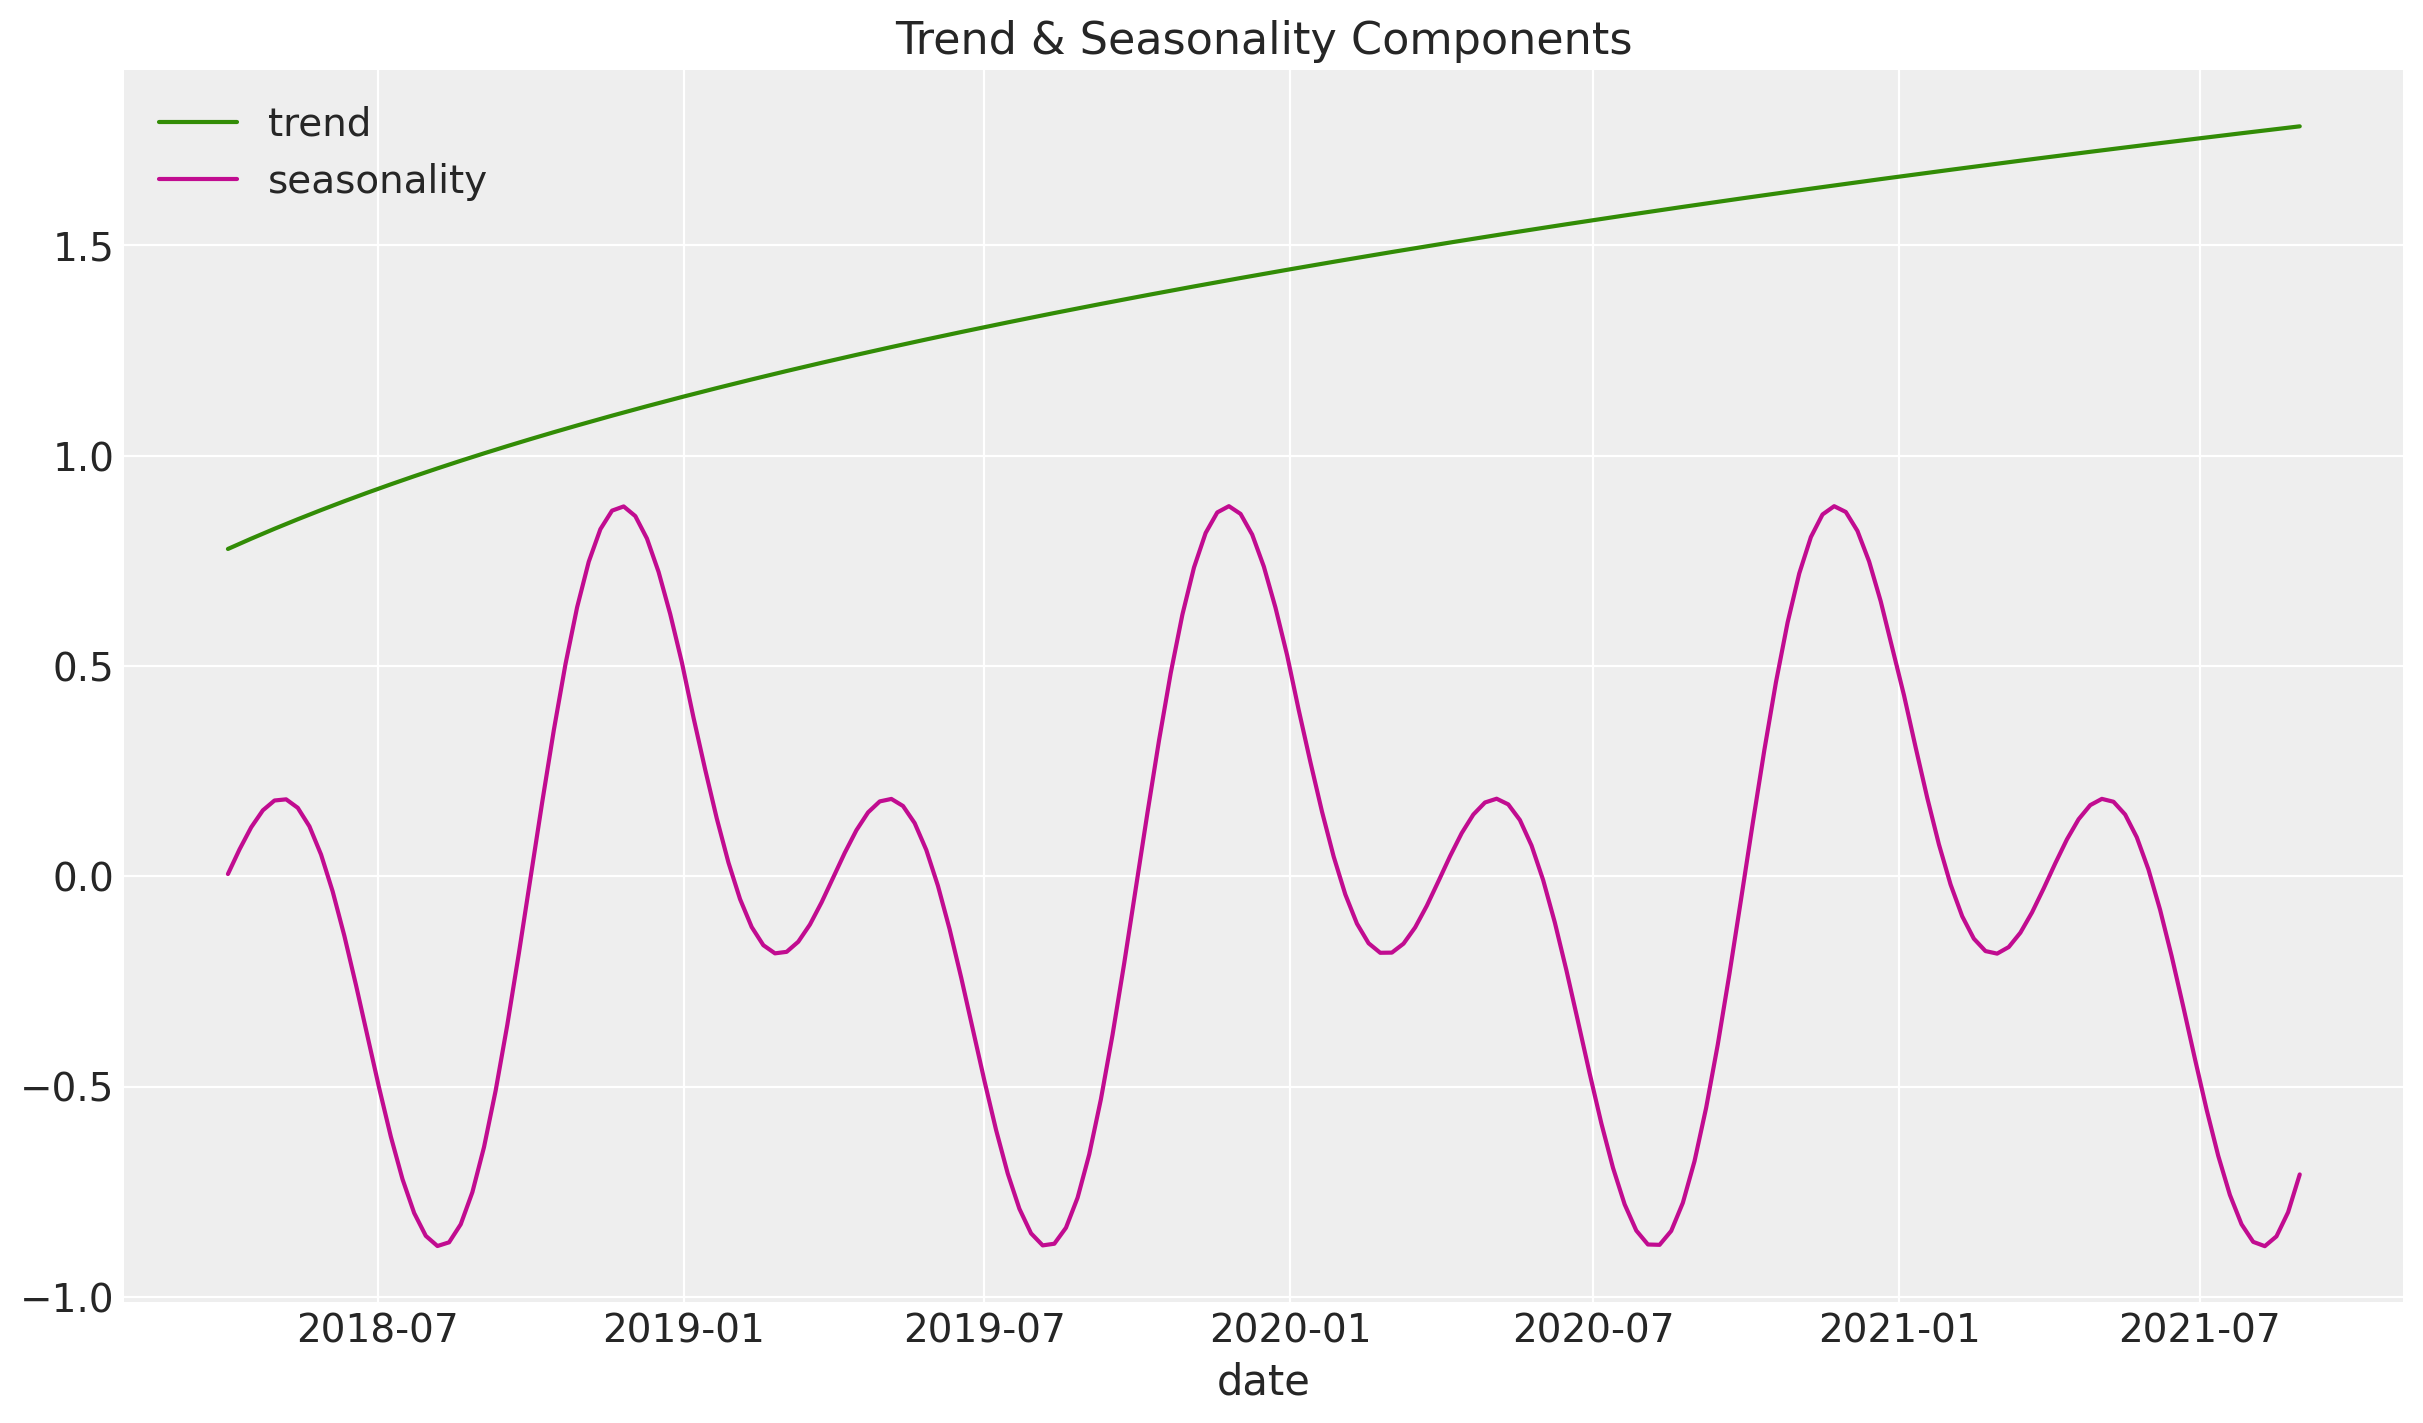

In [7]:
df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

df["cs"] = - np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5) 
df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="trend", color="C2", label="trend", data=df, ax=ax)
sns.lineplot(x="date_week", y="seasonality", color="C3", label="seasonality", data=df, ax=ax)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", xlabel="date", ylabel=None);

### 4. Control Variables

We add two *events* where there was a remarkable peak in our target variable. We assume they are independent an not seasonal (e.g. launch of a particular product). 

In [8]:
df["event_1"] = (df["date_week"] == "2019-05-13").astype(float)
df["event_2"] = (df["date_week"] == "2020-09-14").astype(float)

### 5. Target Variable

Finally, we define the target variable (sales) $y$. We assume it is a linear combination of the effect signal, the trend and the seasonal components, plus the two events and an intercept. We also add some Gaussian noise.

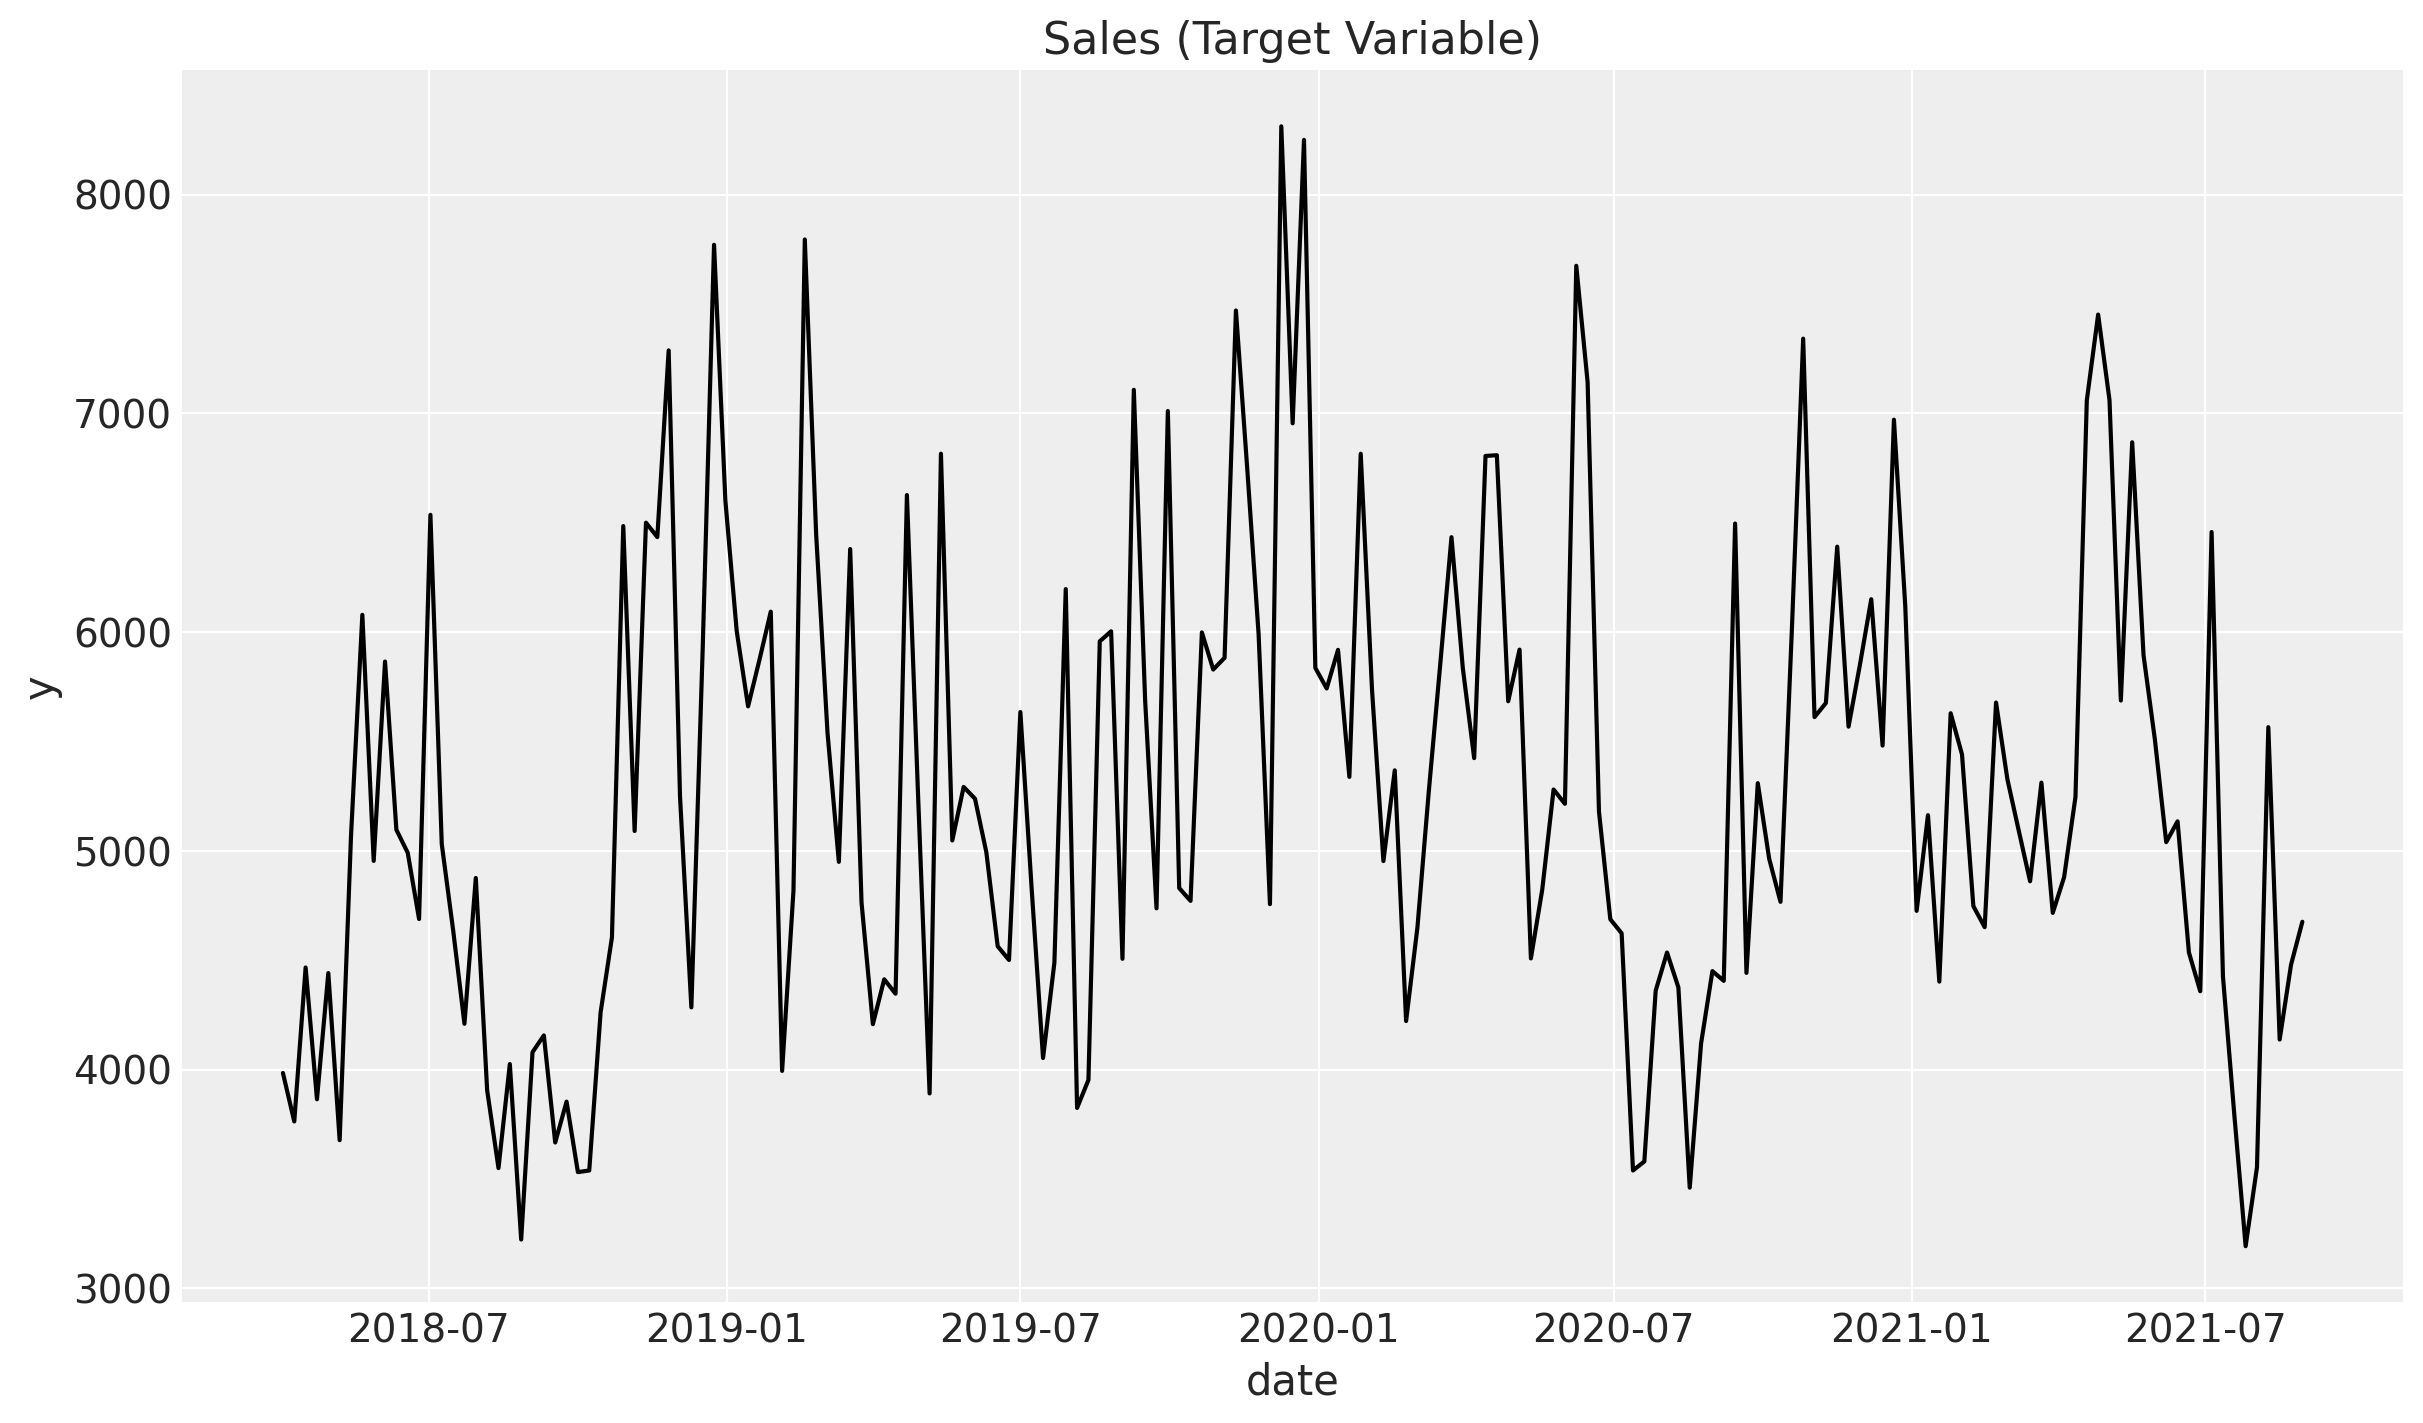

In [9]:
df["intercept"] = 2.0
df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n)


df["y"] = 1_000 * (
    df["intercept"]
    + df["trend"]
    + df["seasonality"]
    + 1.5 * df["event_1"]
    + 2.5 * df["event_2"]
    + 3 * df["z1_adstock_saturated"]
    + 2 * df["z2_adstock_saturated"]
    + df["epsilon"]
)

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="y", color="black", data=df, ax=ax)
ax.set(title="Sales (Target Variable)", xlabel="date", ylabel="y");

We of course will not have all of these features in our real data. Let's filter out the features we will use for modeling:

In [10]:
columns_to_keep = [
    "date_week",
    "y",
    "z1",
    "z2",
    "event_1",
    "event_2",
    "dayofyear",
]

data_df = df[columns_to_keep].copy()

data_df.head()

date_week            y        z1   z2  event_1  event_2  dayofyear
0 2018-04-02  3984.662237  0.318580  0.0      0.0      0.0         92
1 2018-04-09  3762.871794  0.112388  0.0      0.0      0.0         99
2 2018-04-16  4466.967388  0.292400  0.0      0.0      0.0        106
3 2018-04-23  3864.219373  0.071399  0.0      0.0      0.0        113
4 2018-04-30  4441.625278  0.386745  0.0      0.0      0.0        120

---

# Part II: Modeling

On this second part, we focus on the modeling process. We will use the data generated in Part I.

## 1. Feature Engineering

Assuming we did an EDA and we have a good understanding of the data (we do not do it here as we generated the data ourselves, but please never skip the EDA!), we can start building our model. One thing we immediately see is the seasonality and the trend component. We can generate features ourselves as *control variables* ( we expect to have a trend and seasonality components in the model API in future releases).

- For the seasonality component we use Fourier modes (similar as in [Prophet](https://facebook.github.io/prophet/)). We use 4 modes for the seasonality component.
- For thr trend component we simply use a linear trend.

In [11]:
# Fourier modes
fourier_modes = generate_fourier_modes(
    periods=data_df["dayofyear"] / 365.25,
    n_order=2
)

# trend feature

data_df["t"] = range(n)

data_df = pd.concat([data_df, fourier_modes], axis=1)

data_df.head()

date_week            y        z1   z2  event_1  event_2  dayofyear  t  \
0 2018-04-02  3984.662237  0.318580  0.0      0.0      0.0         92  0   
1 2018-04-09  3762.871794  0.112388  0.0      0.0      0.0         99  1   
2 2018-04-16  4466.967388  0.292400  0.0      0.0      0.0        106  2   
3 2018-04-23  3864.219373  0.071399  0.0      0.0      0.0        113  3   
4 2018-04-30  4441.625278  0.386745  0.0      0.0      0.0        120  4   

   sin_order_1  cos_order_1  sin_order_2  cos_order_2  
0     0.999930    -0.011826    -0.023651    -0.999720  
1     0.991269    -0.131859    -0.261414    -0.965227  
2     0.968251    -0.249981    -0.484089    -0.875019  
3     0.931210    -0.364483    -0.678820    -0.734304  
4     0.880683    -0.473706    -0.834370    -0.551205

## 2. Model Specification

Now that we have the data in place, lets use the `DelayedSaturatedMMM` class to define the model.

In [12]:
mmm = DelayedSaturatedMMM(
    data_df=data_df,
    target_column="y",
    date_column="date_week",
    channel_columns=["z1", "z2"],
    control_columns=[
        "event_1",
        "event_2",
        "t",
        "sin_order_1",
        "cos_order_1",
        "sin_order_2",
        "cos_order_2",
    ],
    adstock_max_lag=8,
)

You can access `pymc` model as `mmm.model`.

In [13]:
type(mmm.model)

pymc.model.Model

We can easily see the explicit model structure:

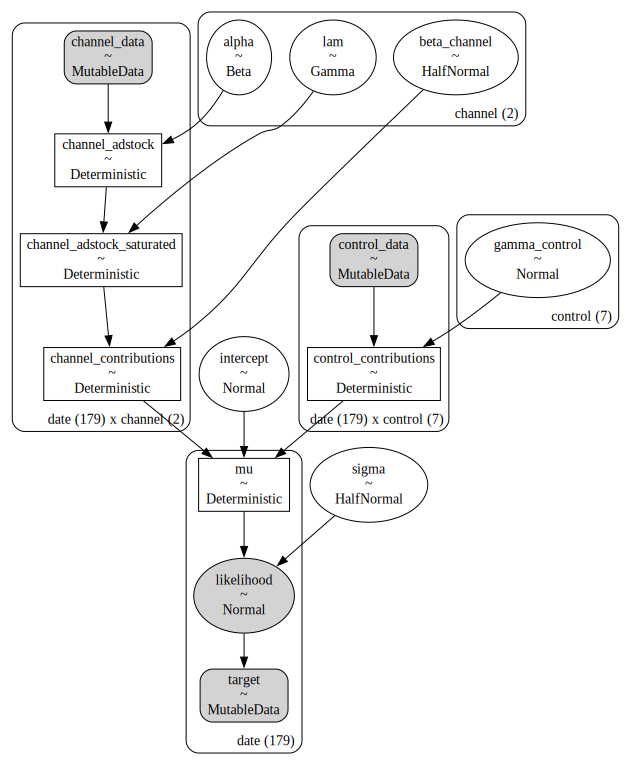

In [14]:
pm.model_to_graphviz(model=mmm.model)

Observe how the media transformations were handled by the class `DelayedSaturatedMMM`.

## 3. Model Fitting

We can now fir the model:

In [15]:
mmm.fit(target_accept=0.95, chains=4, draws=1_000, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, sigma, gamma_control]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 99 seconds.
Sampling: [likelihood]


## 4. Model Diagnostics

The `fit_result` attribute contains the `pymc` trace object.

In [16]:
mmm.fit_result

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

We can therefore use all the `pymc` machinery to run model diagnostics.Firts, let's see the summary of the trace:

In [17]:
az.summary(
    data=mmm.fit_result,
    var_names=["intercept", "beta_channel", "alpha",  "lam", "gamma_control", "sigma"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept        -0.056  0.021  -0.095   -0.018      0.000    0.000    3132.0   
beta_channel[z1]  0.587  0.029   0.533    0.645      0.001    0.000    2881.0   
beta_channel[z2]  0.434  0.120   0.313    0.609      0.004    0.003    1654.0   
alpha[z1]         0.397  0.028   0.345    0.449      0.000    0.000    3478.0   
alpha[z2]         0.193  0.040   0.113    0.267      0.001    0.001    2316.0   
lam[z1]           4.072  0.361   3.372    4.748      0.006    0.004    3233.0   
lam[z2]           3.169  1.150   1.150    5.258      0.028    0.020    1661.0   
gamma_control[0]  0.399  0.049   0.309    0.494      0.001    0.000    5197.0   
gamma_control[1]  0.531  0.050   0.439    0.624      0.001    0.000    6000.0   
gamma_control[2]  0.001  0.000   0.001    0.001      0.000    0.000    4029.0   
gamma_control[3]  0.005  0.005  -0.005    0.015      0.000    0.000    5086.0   
gamma_control[4]  0.102  0.005   0.092    0.112      0.000    0.000    5975.0   
gamma_control[5] -0.093  0.006  -0.103   -0.083      0.000    0.000    5380.0   
gamma_control[6]  0.003  0.005  -0.007    0.014      0.000    0.000    5052.0   
sigma             0.049  0.003   0.044    0.054      0.000    0.000    4925.0   

                  ess_tail  r_hat  
intercept           2270.0    1.0  
beta_channel[z1]    2667.0    1.0  
beta_channel[z2]    1339.0    1.0  
alpha[z1]           3263.0    1.0  
alpha[z2]           2162.0    1.0  
lam[z1]             2370.0    1.0  
lam[z2]             1344.0    1.0  
gamma_control[0]    2321.0    1.0  
gamma_control[1]    2832.0    1.0  
gamma_control[2]    2992.0    1.0  
gamma_control[3]    2884.0    1.0  
gamma_control[4]    2792.0    1.0  
gamma_control[5]    2465.0    1.0  
gamma_control[6]    2903.0    1.0  
sigma               2127.0    1.0

Observe that the estimated parameters for $\alpha$ and $\lambda$ are very close to the ones we set in the data generation process! Let's plot the trace for the parameters:

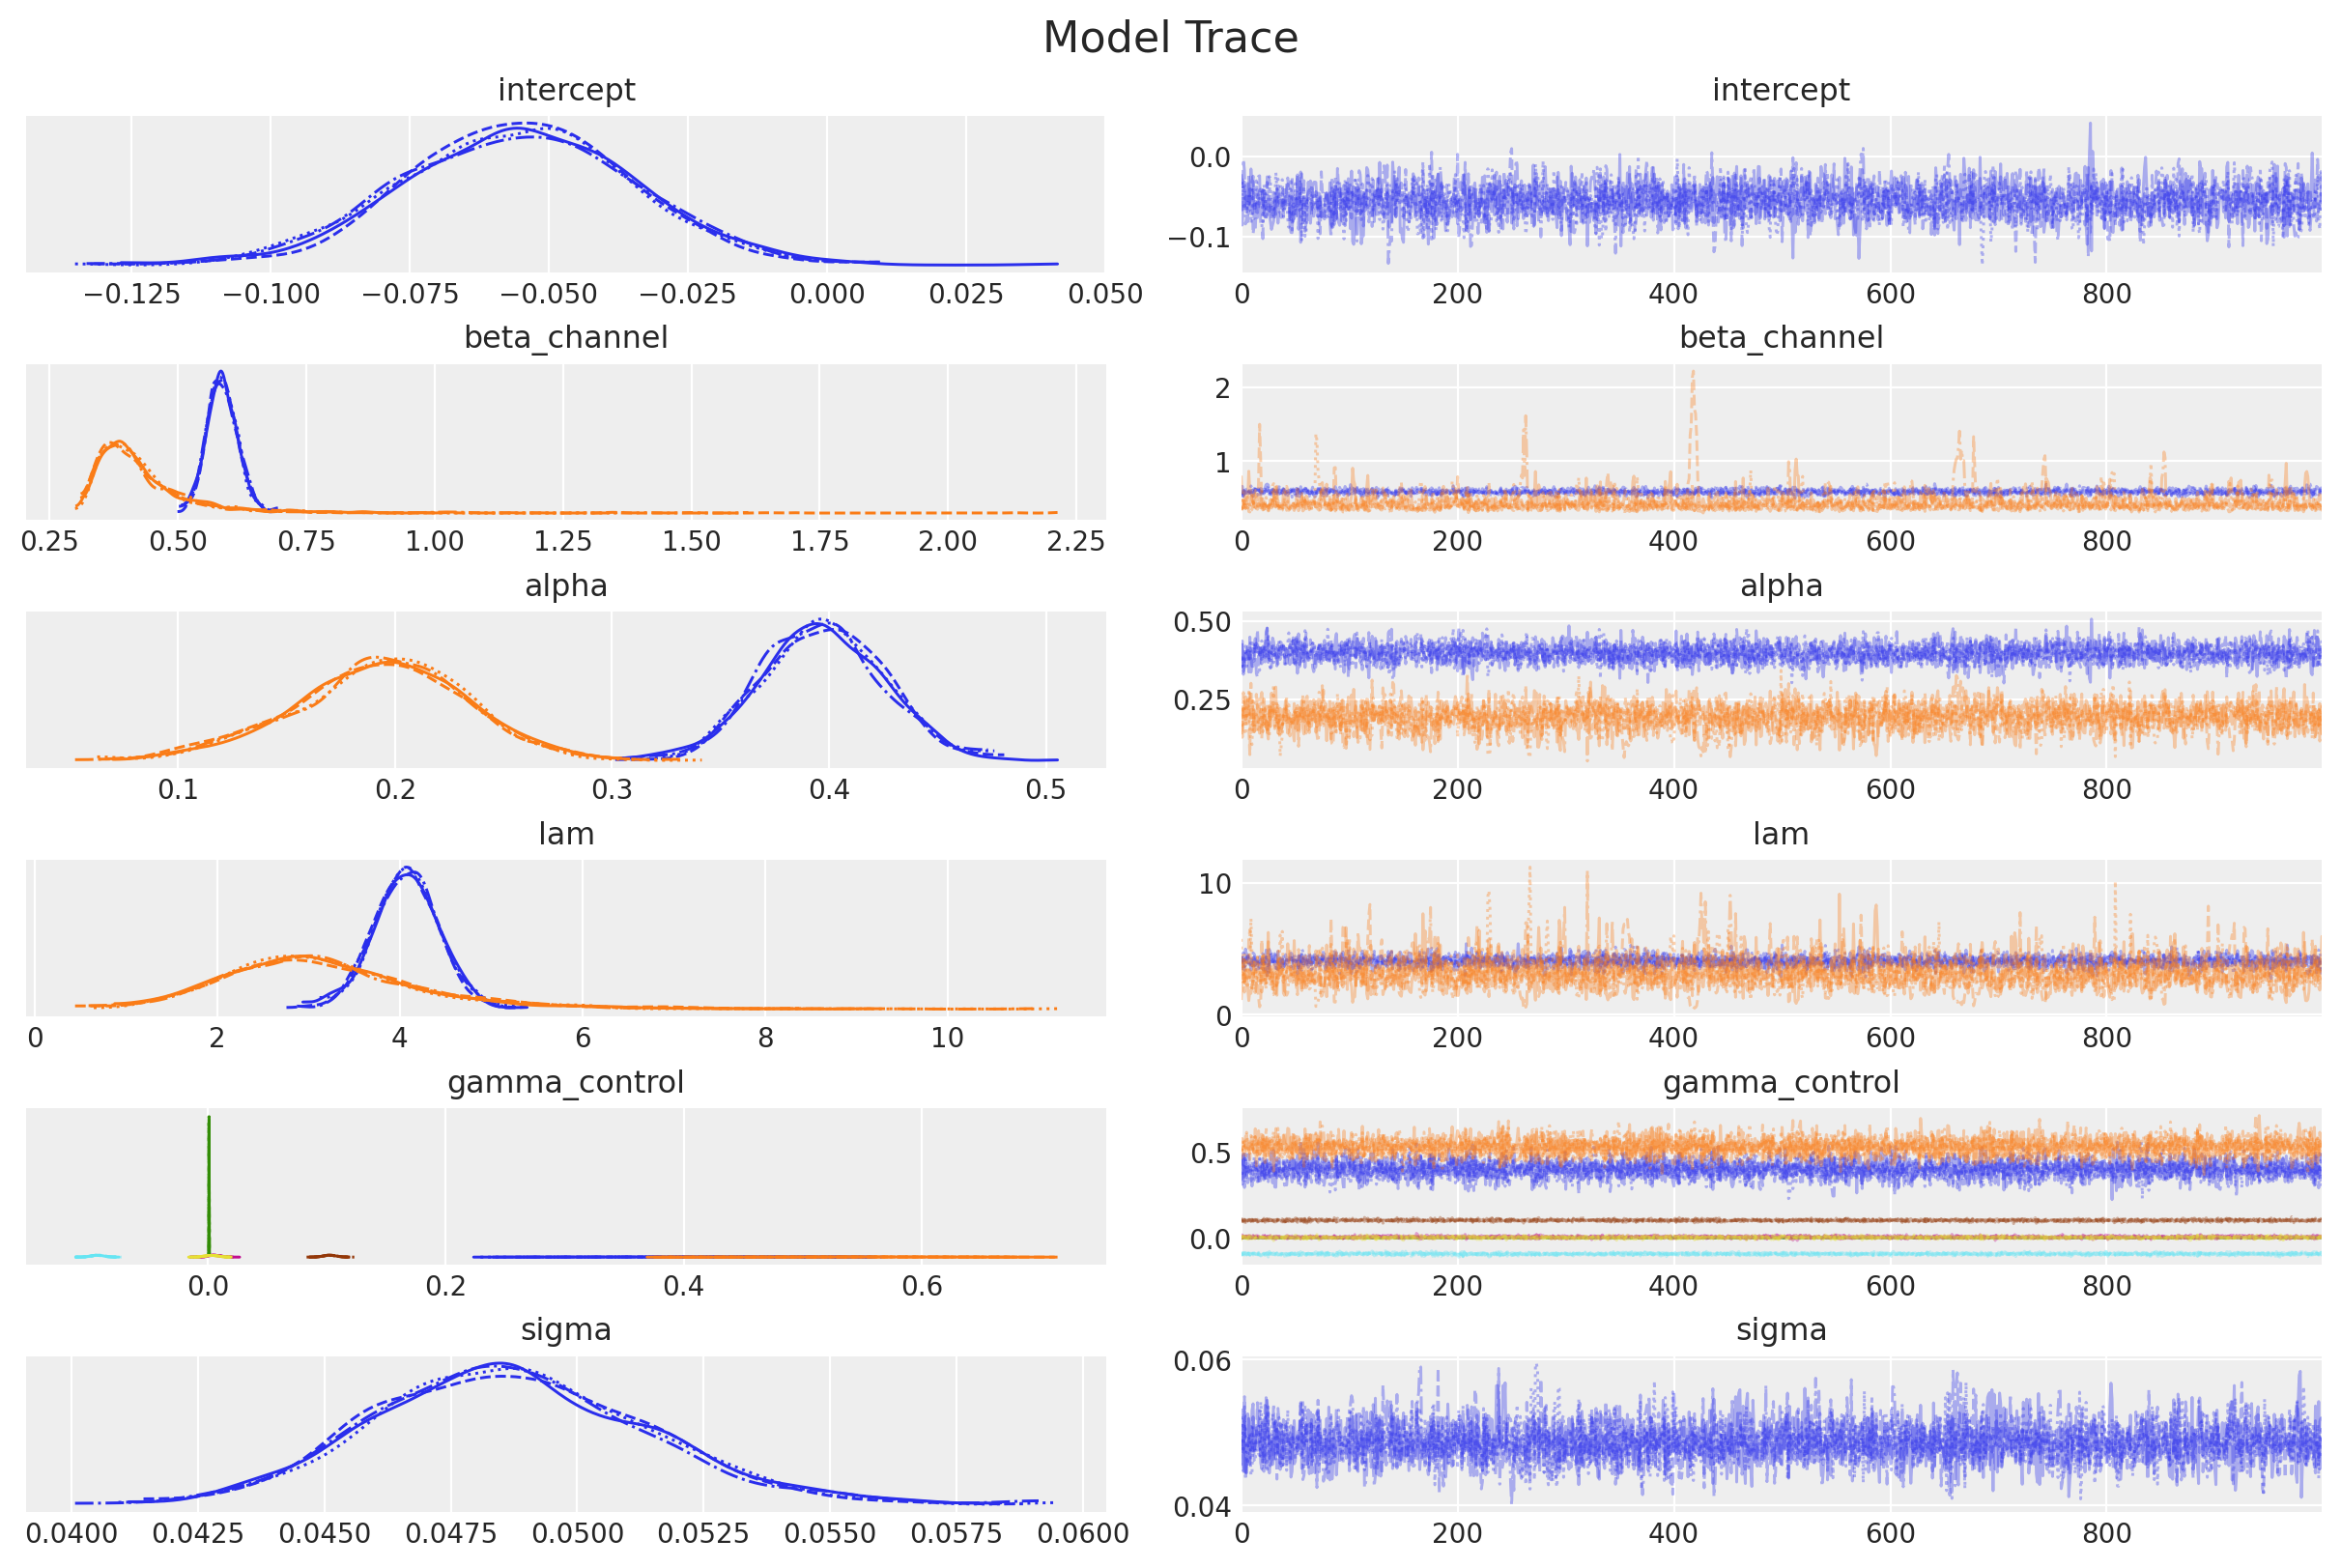

In [18]:
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=["intercept", "beta_channel", "alpha",  "lam", "gamma_control", "sigma"],
    compact=True,
    backend_kwargs={"figsize": (12, 8), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

Next, we can plot the posterior predictive distribution for the target variable:

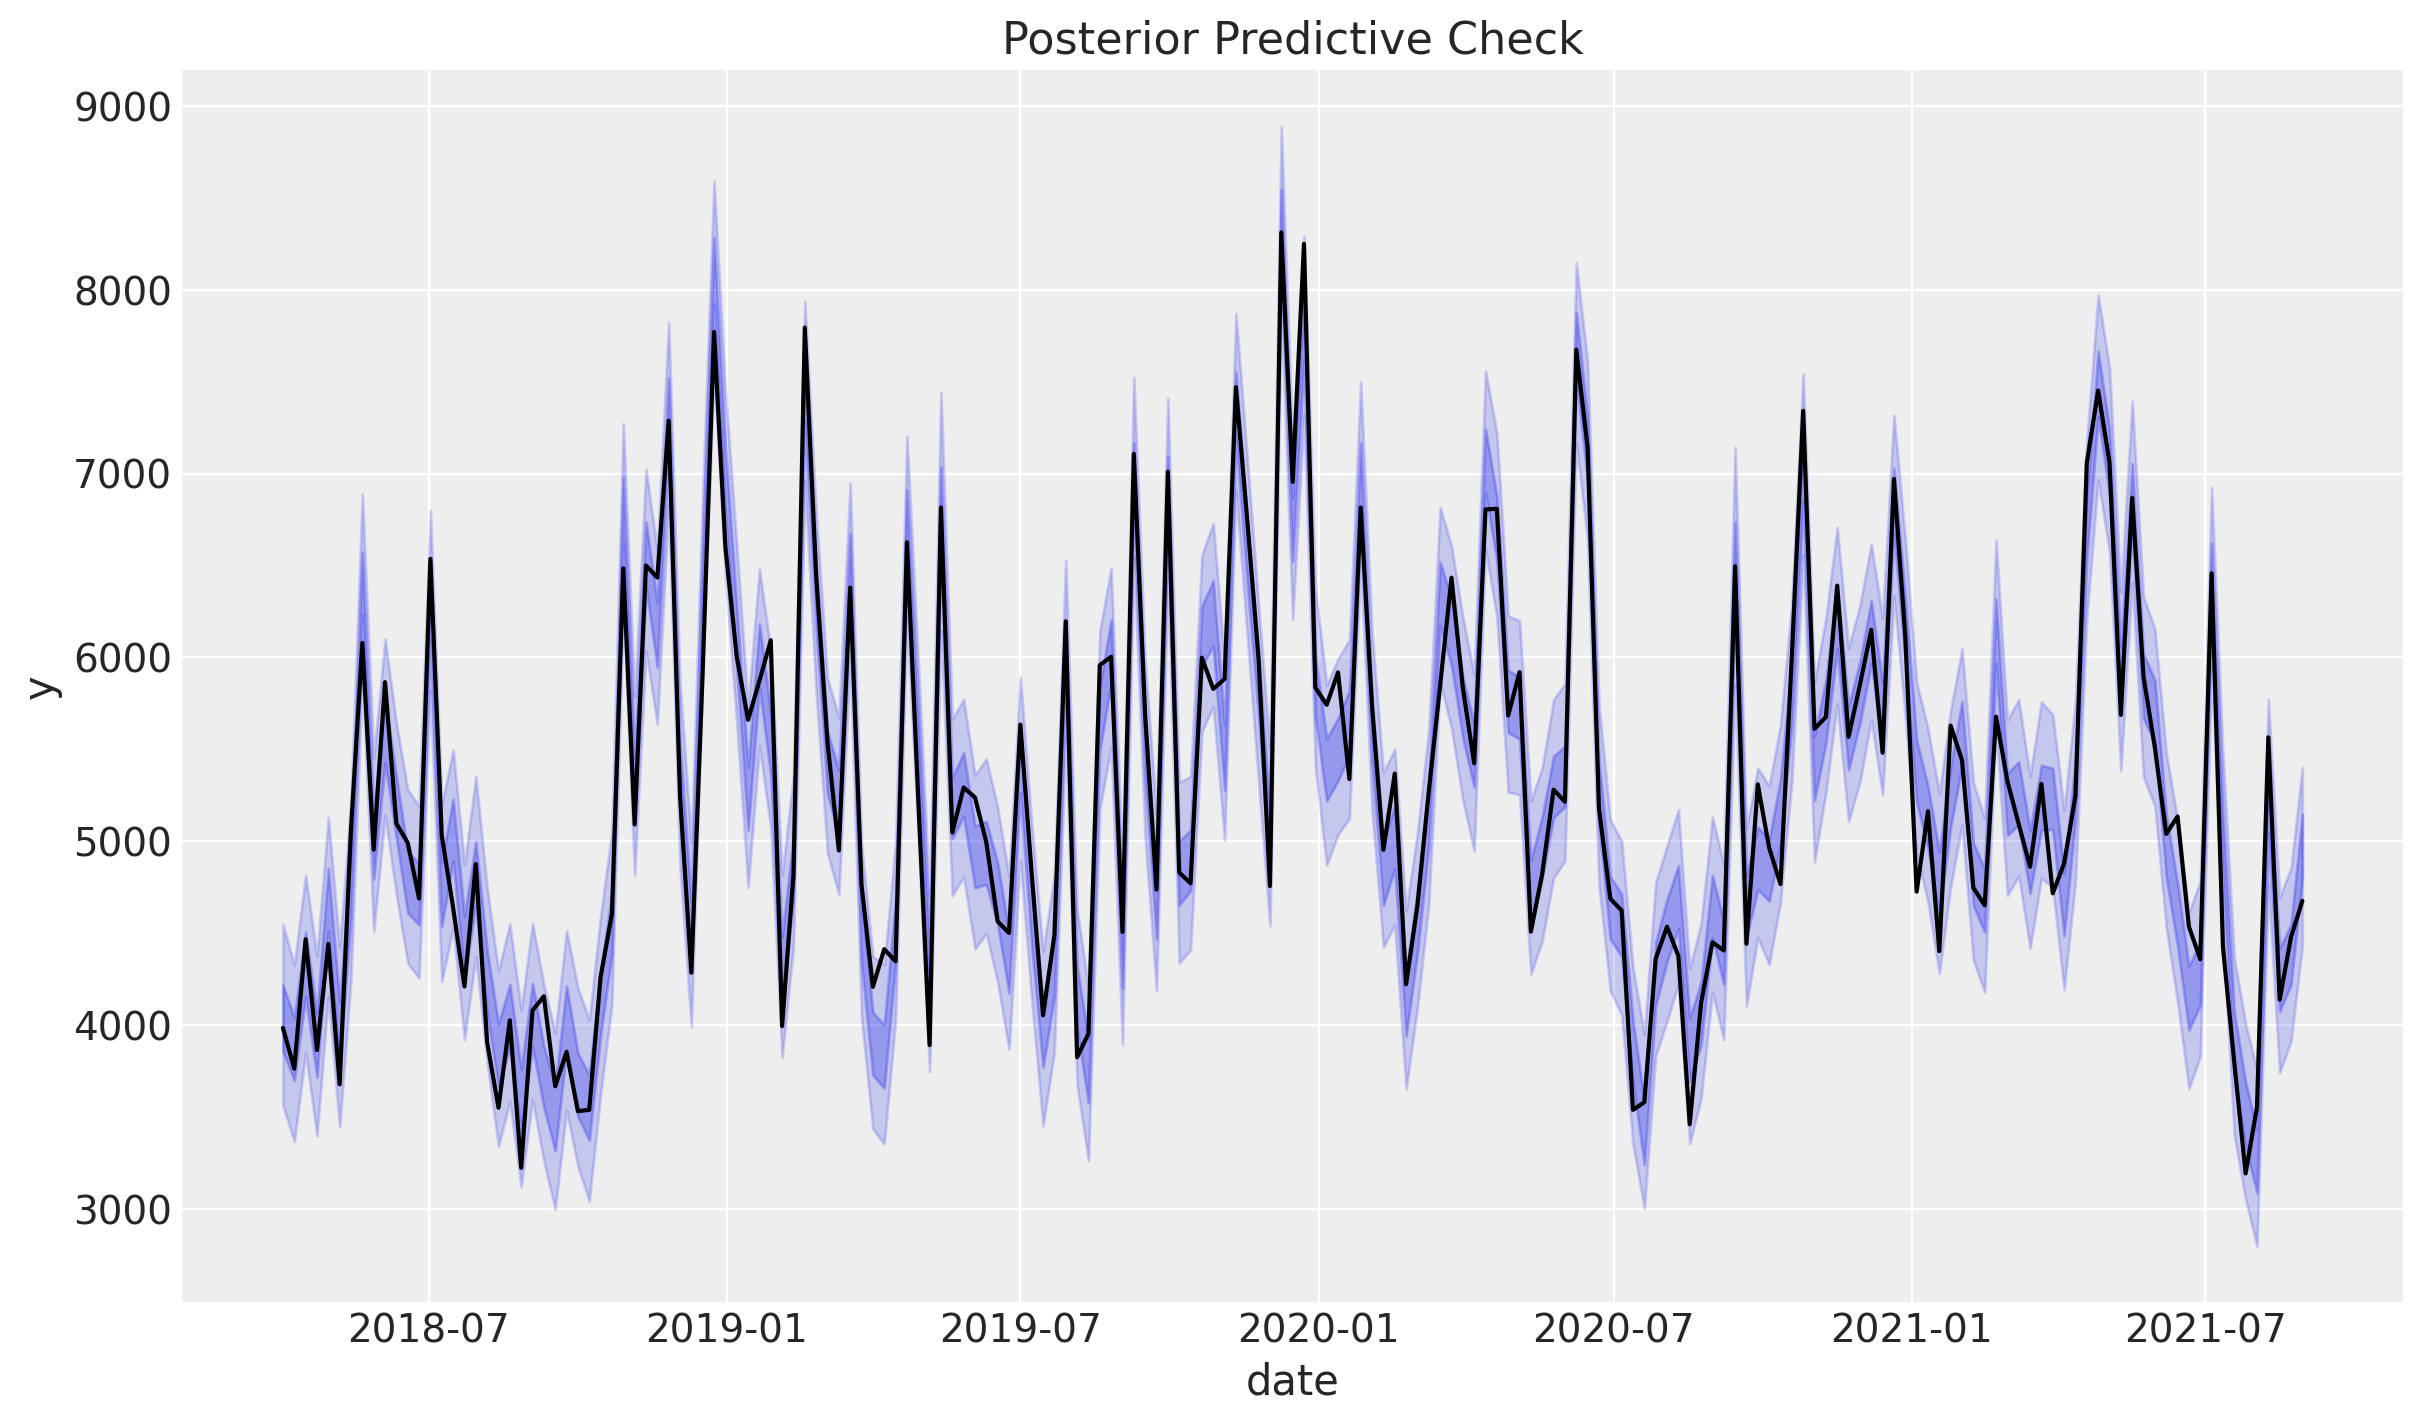

In [19]:
mmm.plot_posterior_predictive(original_scale=True);

The fit looks very good (as expected)!

We can decompose the posterior predictive distribution into the different components:

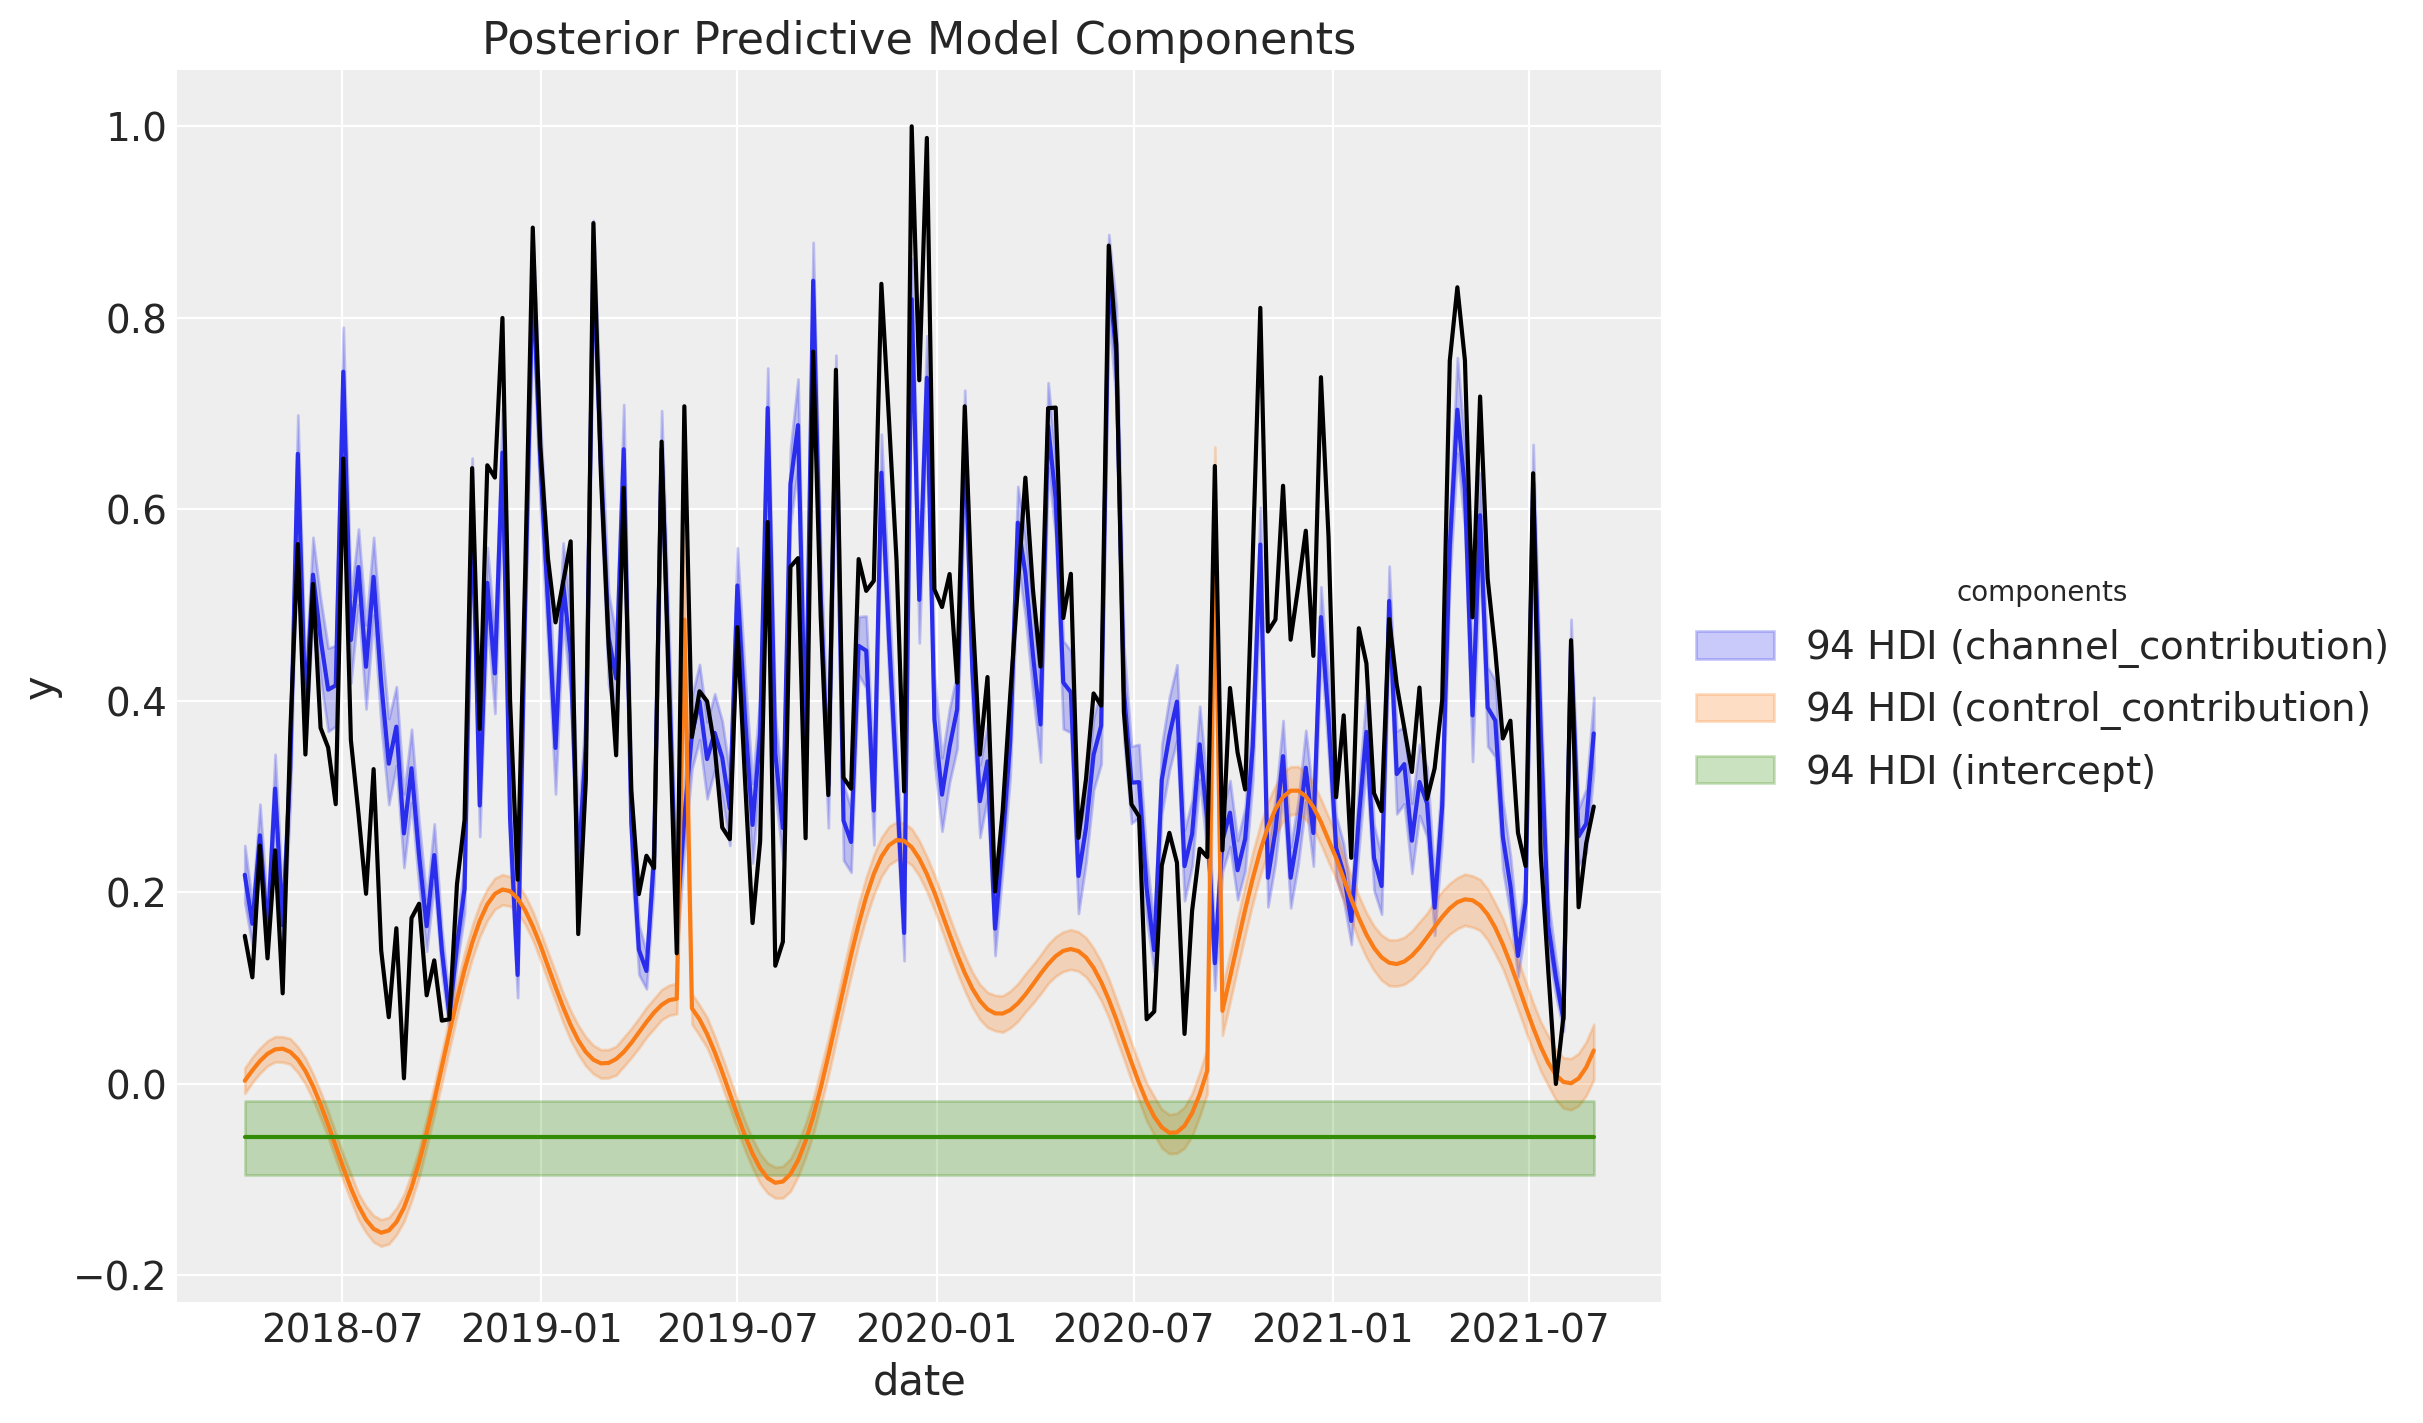

In [20]:
mmm.plot_components_contributions();

## 5. Media Parameters

We can deep-dive into the media transformation parameters. We want to compare the posterior distributions against the true values.

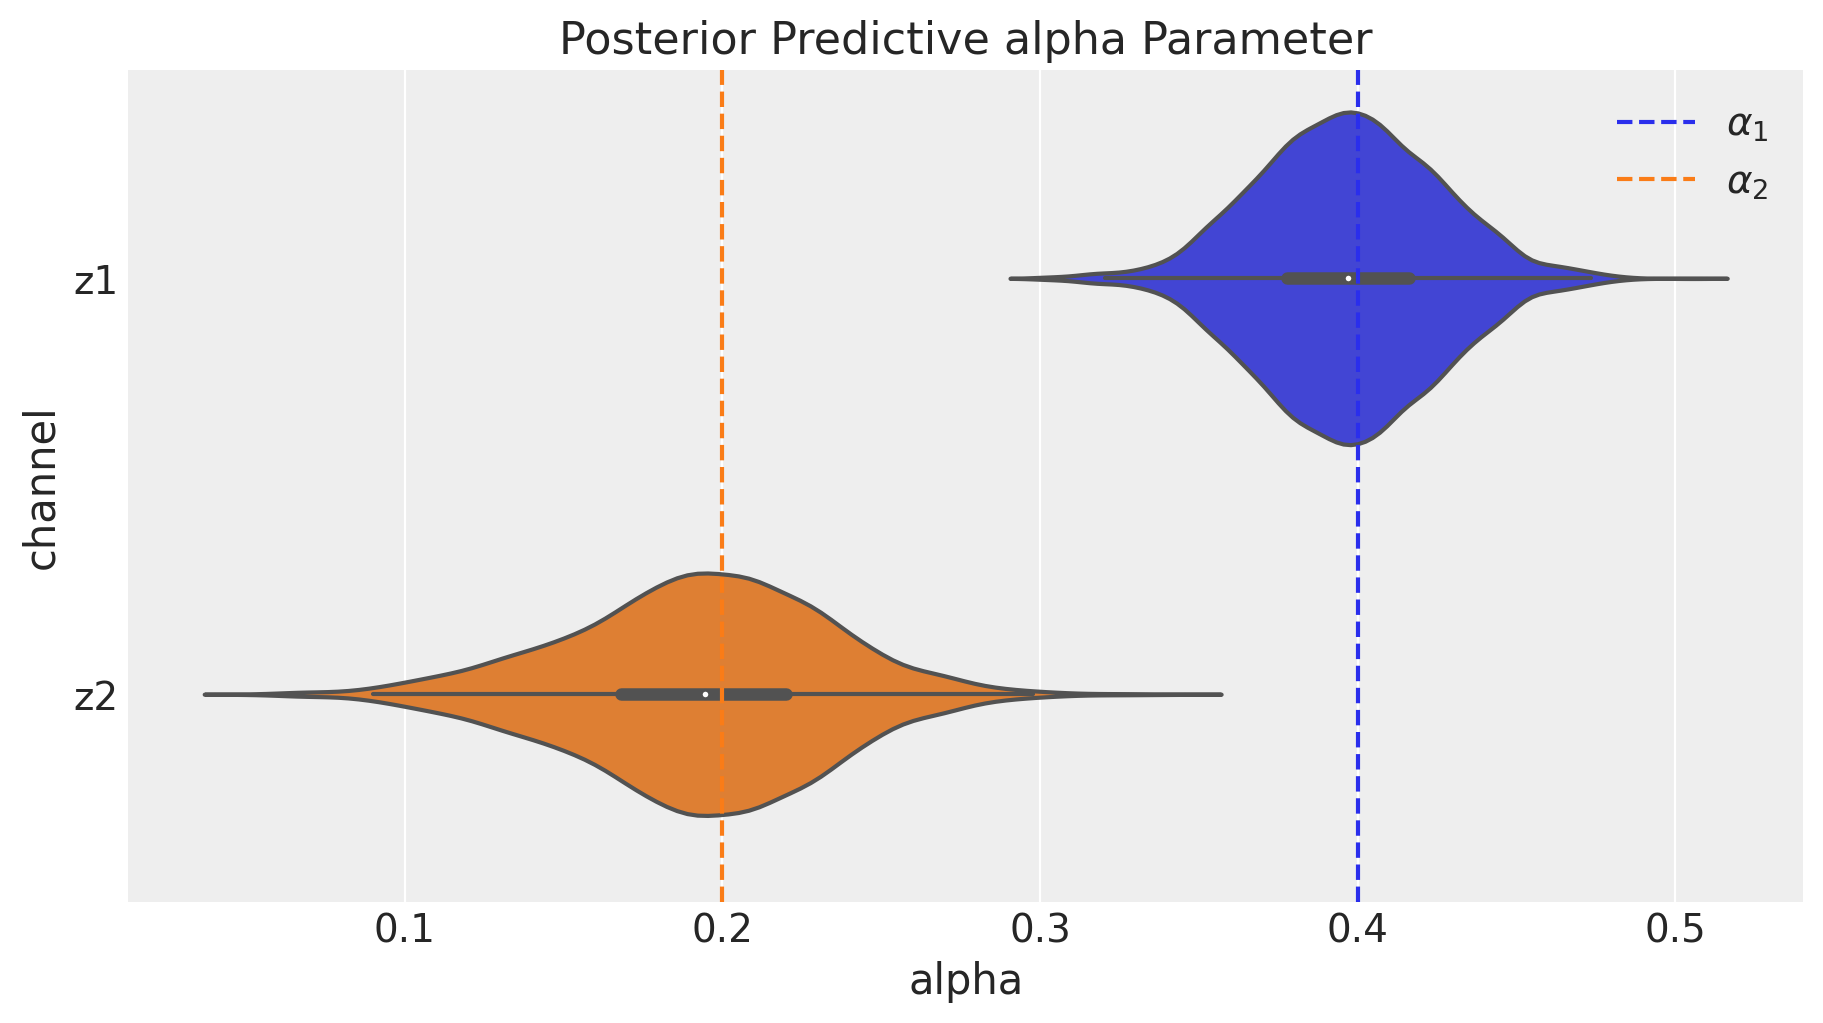

In [21]:
fig = mmm.plot_channel_parameter(param_name="alpha", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=alpha1, color="C0", linestyle="--", label=r"$\alpha_1$")
ax.axvline(x=alpha2, color="C1", linestyle="--", label=r"$\alpha_2$")
ax.legend(loc="upper right");

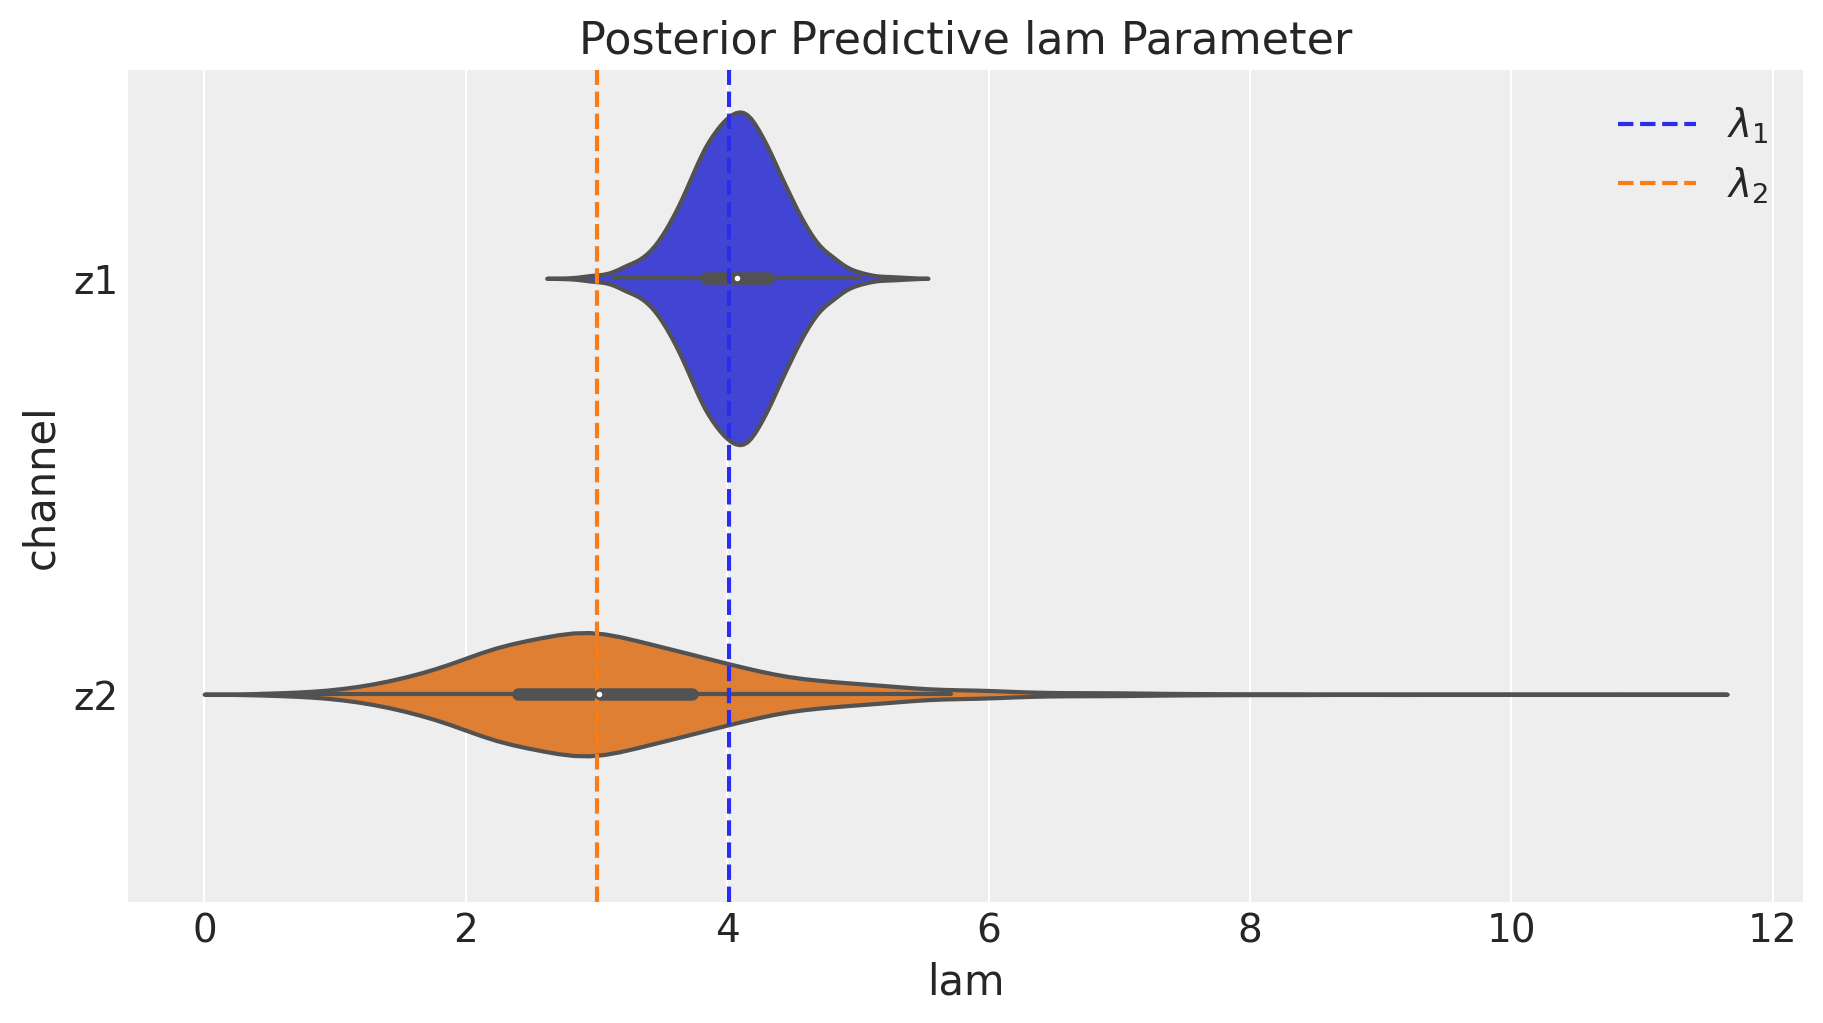

In [22]:
fig = mmm.plot_channel_parameter(param_name="lam", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=lam1 / data_df["z1"].max(), color="C0", linestyle="--", label=r"$\lambda_1$")
ax.axvline(x=lam2, color="C1", linestyle="--", label=r"$\lambda_2$")
ax.legend(loc="upper right");

We indeed see that our media parameter were successfully recovered!

## 6. Media Deep-Dive

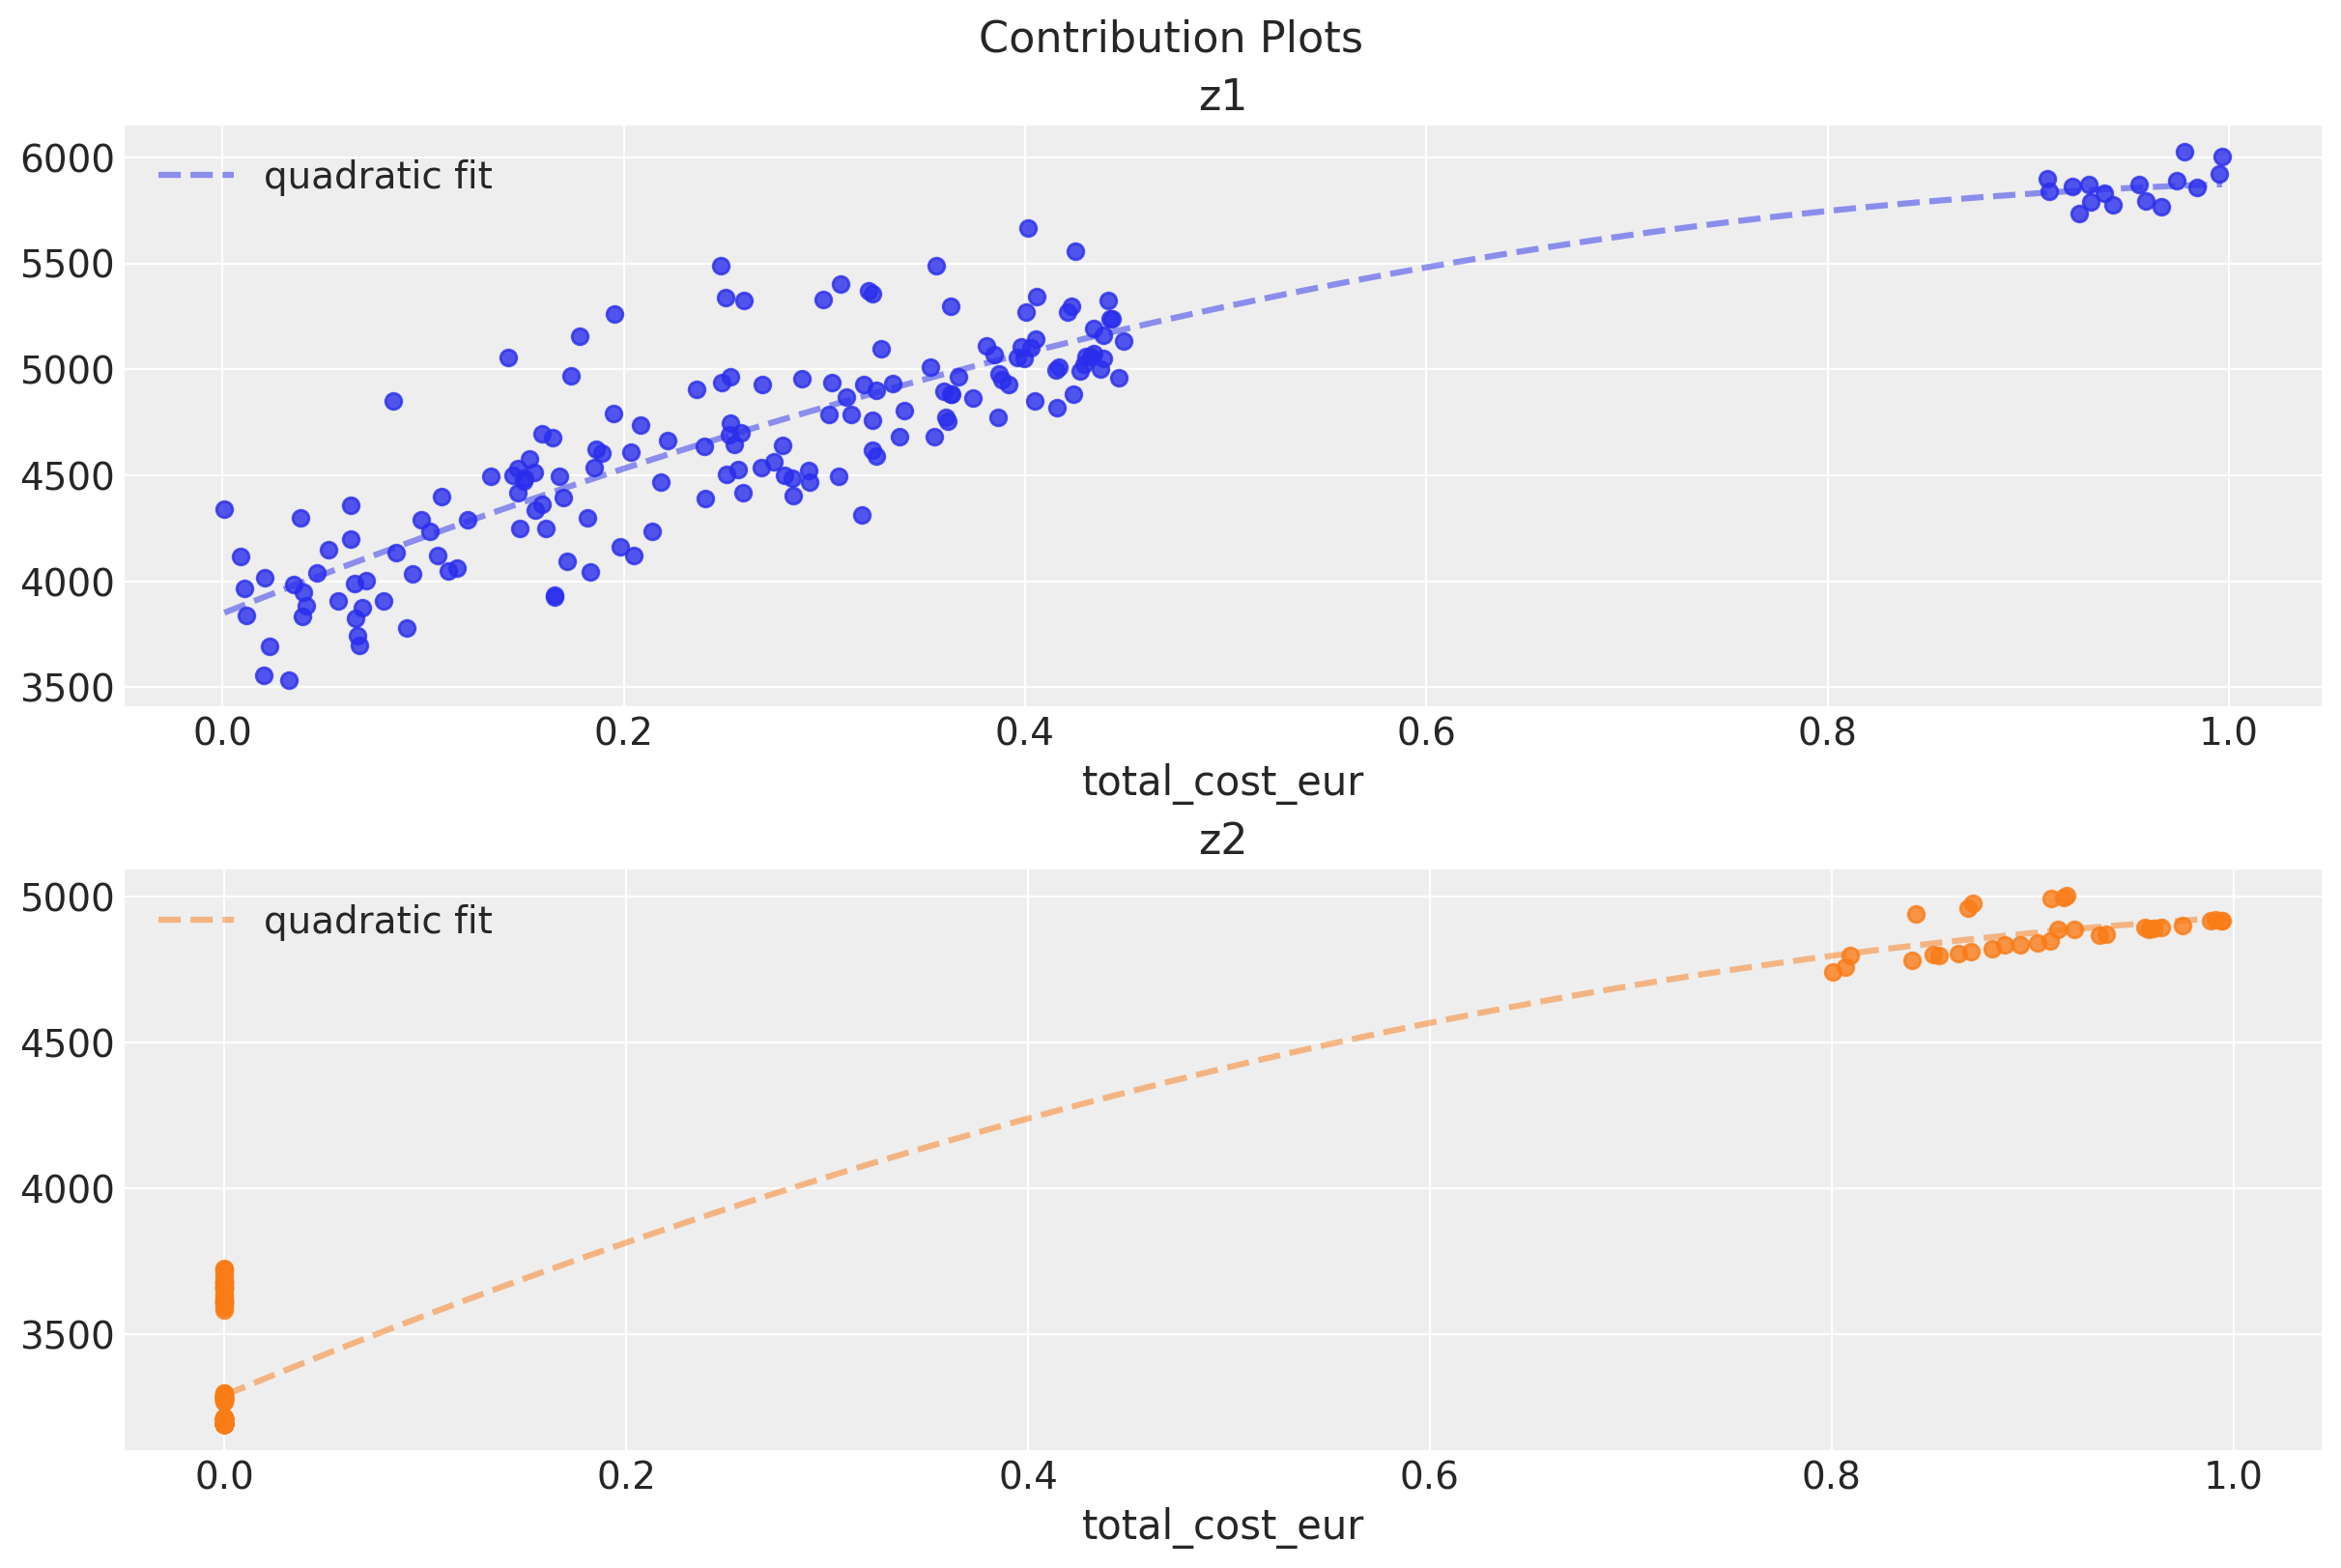

In [24]:
mmm.plot_contribution_curves();

### 7. Contribution  Recovery

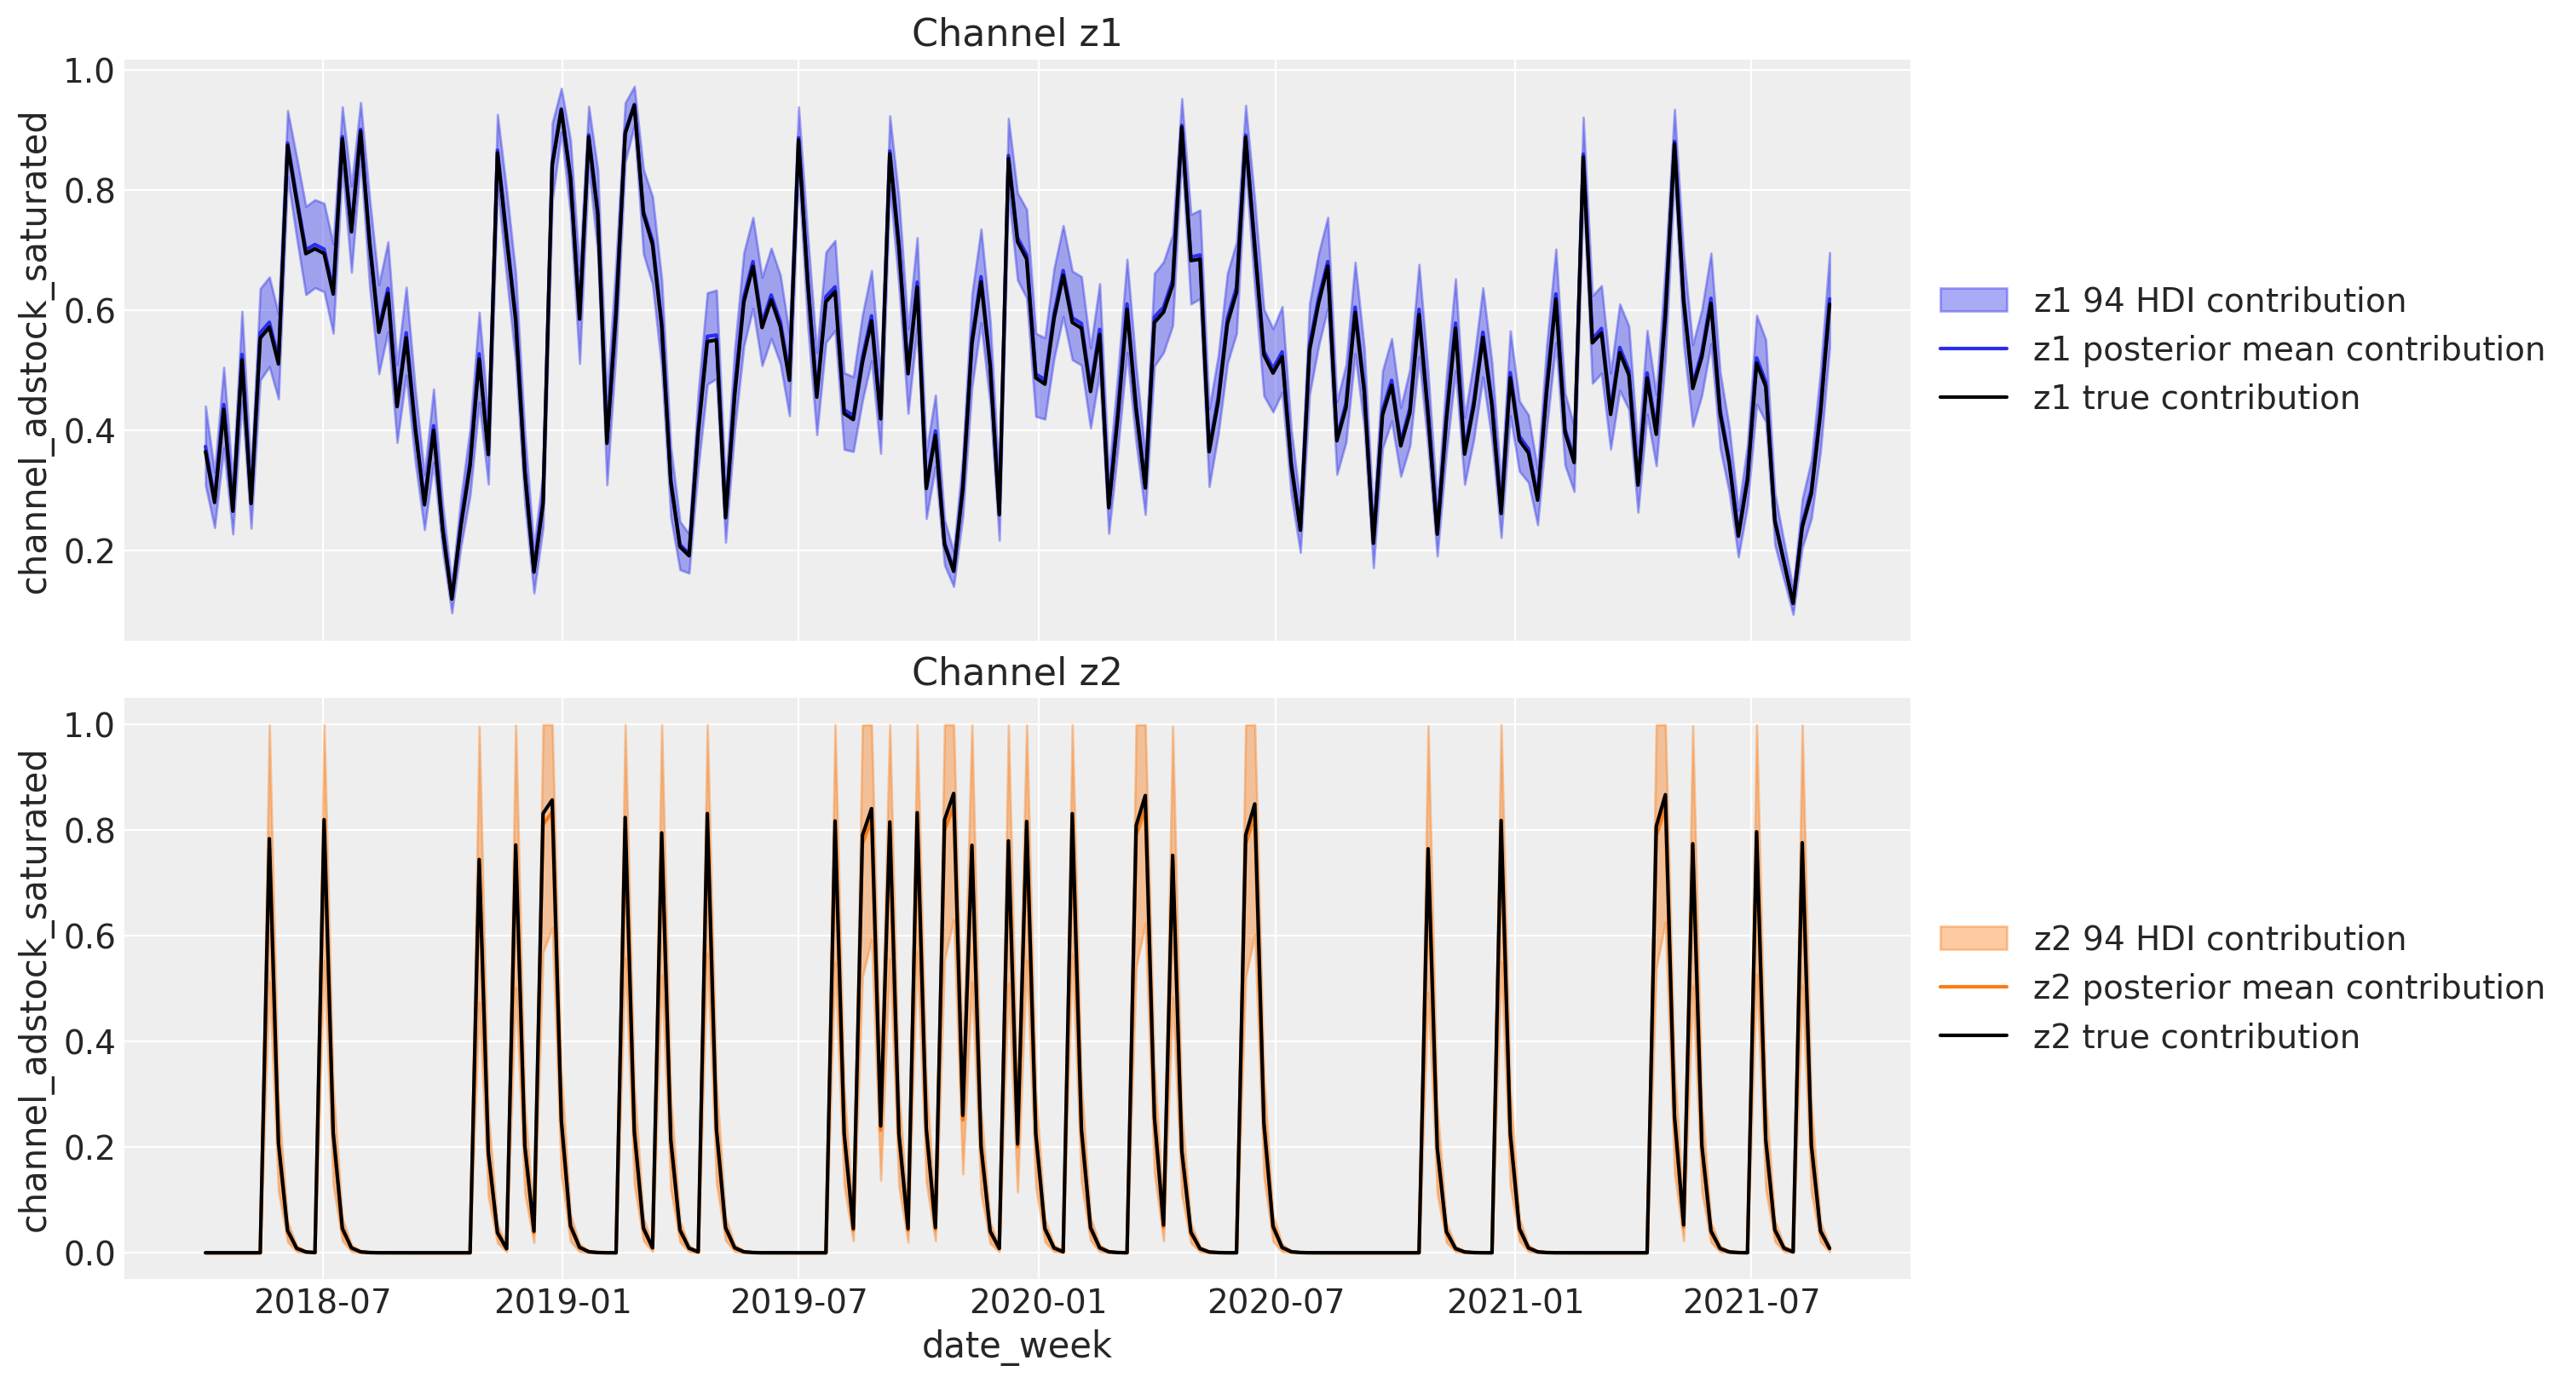

In [41]:
mean_estimated_channels_contribution = az.extract(
    data=mmm.fit_result,
    group="posterior",
    var_names=["channel_adstock_saturated"]
).mean("sample")

estimated_channels_contribution_hdi = az.hdi(ary=mmm.fit_result)["channel_adstock_saturated"]

fig, ax = plt.subplots(
    nrows=2, figsize=(15, 8), ncols=1, sharex=True, sharey=False, layout="constrained"
)

for i, z, in enumerate(["z1", "z2"]):
    ax[i].fill_between(
        x=df["date_week"],
        y1=estimated_channels_contribution_hdi[:, i, 0],
        y2=estimated_channels_contribution_hdi[:, i, 1],
        color=f"C{i}",
        label=f"{z} $94%$ HDI contribution",
        alpha=0.4,
    )
    sns.lineplot(
        x=df["date_week"],
        y=mean_estimated_channels_contribution.sel(channel=z),
        color=f"C{i}",
        label=f"{z} posterior mean contribution",
        ax=ax[i]
    )
    sns.lineplot(
        x="date_week",
        y=f"{z}_adstock_saturated",
        data=df, color="black",
        label=f"{z} true contribution",
        ax=ax[i]
    )
    ax[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax[i].set(title=f"Channel {z}")